 # PAOO6: Marketing strategy for bank customers

## Planejamento da solução (IoT)

### Input

1. Business case
    * Customer segmentation
2. Data set
    * the last six months with approximately 9k customers active credit card.
        - There are 18 columns.

### Output

1. Data Analysis


2. Reports with the answers to busisness questions

    1. Create a customer segmentation based on clear selection criteria.
        - RMF
    2. Make customer segmentation accessible to the operations team.
        - Dashboard
        - Streamlit
        - Metabase
    3. Teach the operations team how to use your solution.
    4. Transfer knowledge to International Bank Data Scientists.
    5. Recommend 2-3 business levers for each customer segment.

3. Machine learning algorithm available in an API


### Tasks

- Data Description 
    - Replace NA
.
- EDA

    - Univariate Analisys.
    - Bivariate Analisys.
    - Multivariate Analisys.
    - Check outlier
    - Space study
    - Embedding definition
.
- ML Training

    - Performance analysis.
    - Cluster analysis.
    - The definition of the cluster numbers.
.
- EDA Insights Analysis
    - Explanation about segmentations' features.
    - Cloud architecture with diagrams(https://diagrams.mingrammer.com/docs/getting-started/examples)
        - AWS architecture.
         - S3 store data 
         - EC2 store ETL and visualization tools.
         - DB 
         - Cronjob analysis
         - Papermill


- CUSTID : Identification of Credit Card holder (Categorical)
- BALANCE : Balance amount left in their account to make purchases (
- BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES : Amount of purchases made from account
- ONEOFFPURCHASES : Maximum purchase amount done in one-go
- INSTALLMENTSPURCHASES : Amount of purchase done in installment
- CASHADVANCE : Cash in advance given by the user
- PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
- CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
- PURCHASESTRX : Numbe of purchase transactions made
- CREDITLIMIT : Limit of Credit Card for user
- PAYMENTS : Amount of Payment done by user
- MINIMUM_PAYMENTS : Minimum amount of payments made by user
- PRCFULLPAYMENT : Percent of full payment paid by user
- TENURE : Tenure of credit card service for user

# 0.0 IMPORTS

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import sweetviz as sv

from matplotlib import pyplot as plt
from IPython.display import HTML
import inflection
from yellowbrick.cluster import KElbowVisualizer
from scipy.stats               import chi2_contingency,shapiro
from sklearn.preprocessing     import RobustScaler,StandardScaler, MinMaxScaler
from sklearn import cluster as c
from sklearn import metrics as mtr
from sklearn import ensemble as en
from sklearn import decomposition as dd
from sklearn import manifold      as mn
import umap.umap_ as umap
from sklearn import mixture       as mx
from scipy.cluster import hierarchy as hc
from pyod.models.knn import KNN

/home/tc0019/DS/bank_marketing/pa06/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

## 0.1 Helper Functions

In [27]:
def descriptive_statistics(df1_num):

    """
    Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        data ([float64 and int64]): [Insert all numerical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range]
    """
    
    # Central Tendency - mean, meadina
    ct1= pd.DataFrame(df1_num.apply(np.mean)).T
    ct2= pd.DataFrame(df1_num.apply(np.median)).T

    # dispersion - std, min, max, range, skew, kurtosis
    ct3= pd.DataFrame(df1_num.apply(np.std)).T
    ct4= pd.DataFrame(df1_num.apply(min)).T
    ct5= pd.DataFrame(df1_num.apply(max)).T
    ct6= pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
    ct7= pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
    ct8= pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T
    ct9 = pd.DataFrame(df1_num.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T


    # concatenar
    df_statistics= pd.concat([ct4, ct5, ct6, ct1, ct2,ct3, ct7, ct8, ct9]).T
    df_statistics.columns=['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'shapiro']
    df_statistics.round(2)

    return df_statistics

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [30, 10]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading dataset

In [28]:
df_raw=pd.read_csv('/home/tc0019/DS/bank_marketing/data/raw/CC_GENERAL.csv')
df_raw.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE
0  C10001    40.900749           0.818182      95.40              0.00                    95.4      0.000000             0.166667                    0.000000                          0.083333                0.000000                 0              2        1000.0   201.802084        139.509787          0.000000      12
1  C10002  3202.467416           0.909091       0.00              0.00                     0.0   6442.945483             0.000000                    0.000000                          0.000000                0.250000                 4              0        7000.0  4103.032597       1072.340217          0.222222      12
2  C10003  2495.148862           1.000000     773.17            773.17                     0.0      0.000000             1.000000                    1.000000                          0.000000                0.000000                 0             12        7500.0   622.066742        627.284787          0.000000      12
3  C10004  1666.670542           0.636364    1499.00           1499.00                     0.0    205.788017             0.083333                    0.083333                          0.000000                0.083333                 1              1        7500.0     0.000000               NaN          0.000000      12
4  C10005   817.714335           1.000000      16.00             16.00                     0.0      0.000000             0.083333                    0.083333                          0.000000                0.000000                 0              1        1200.0   678.334763        244.791237          0.000000      12

# 1.0 Data Description

In [29]:
df1=df_raw.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

## 1.1 Rename columns

In [30]:
df1.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [31]:
cols_old=['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

df1.columns=cols_new

df1.sample()

cust_id      balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit     payments  minimum_payments  prc_full_payment  tenure
6687  C16874  1243.250958                1.0     1680.0               0.0                  1680.0           0.0                  1.0                         0.0                               1.0                     0.0                 0             12        4500.0  1105.142936        361.880781               0.0      12

## 1.2. Data Dimensions

In [32]:
rows_,columns_=df1.shape

print(f'Number of Rows: {rows_} \nNumber of Cols: {columns_}')

Number of Rows: 8950 
Number of Cols: 18


## 1.3. Data Types

In [33]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check NA

In [34]:
df1.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

### 1.4.1 Remove NA

In [35]:
df1 = df1.dropna(subset=['credit_limit'])
df1.fillna(0, inplace=True)

In [36]:
df1.isna().sum()


cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

In [37]:
df1.shape

(8949, 18)

## 1.5. Descriptive Statistics

In [38]:
df1_num=df1.select_dtypes(include=['int64', 'float64']).round(2)
df1_cat=df1.select_dtypes(exclude=['int64', 'float64', 'datetime'])

### 1.5.1. Numerical Atributes

In [39]:
descriptive_statistics(df1_num)

min       max     range         mean  median          std       skew    kurtosis     shapiro
balance                            0.0  19043.14  19043.14  1564.647591  873.68  2081.467681   2.393271    7.674048  not normal
balance_frequency                  0.0       1.0       1.0     0.877505     1.0     0.237051  -2.031708    3.122858  not normal
purchases                          0.0  49039.57  49039.57  1003.316936  361.49  2136.608461   8.143969  111.379918  not normal
oneoff_purchases                   0.0  40761.25  40761.25   592.503572    38.0  1659.876102  10.044622  164.172057  not normal
installments_purchases             0.0   22500.0   22500.0   411.113579    89.0   904.327674   7.298823   96.567168  not normal
cash_advance                       0.0  47137.21  47137.21   978.959606     0.0  2097.147155   5.166323   52.894097  not normal
purchases_frequency                0.0       1.0       1.0     0.490272     0.5     0.401645   0.060058   -1.639149  not normal
oneoff_purchases_frequency         0.0       1.0       1.0     0.202199    0.08     0.298548   1.536349    1.162469  not normal
purchases_installments_frequency   0.0       1.0       1.0     0.364594    0.17     0.397604   0.508681   -1.399264  not normal
cash_advance_frequency             0.0       1.5       1.5     0.134907     0.0     0.200262   1.830203    3.337418  not normal
cash_advance_trx                   0.0     123.0     123.0     3.249078     0.0     6.824605   5.720976   61.640368  not normal
purchases_trx                      0.0     358.0     358.0    14.711476     7.0    24.857163   4.630493   34.790599  not normal
credit_limit                      50.0   30000.0   29950.0   4494.44945  3000.0  3638.612412   1.522464    2.836656  not normal
payments                           0.0  50721.48  50721.48  1733.336537  857.06  2895.006413   5.907465   54.767276  not normal
minimum_payments                   0.0  76406.21  76406.21   834.075059  289.69   2335.97385  13.807831  292.330718  not normal
prc_full_payment                   0.0       1.0       1.0     0.153551     0.0     0.292644   1.944375    2.435315  not normal
tenure                             6.0      12.0       6.0    11.517935    12.0     1.337059  -2.944788    7.707385  not normal

# 2.0 EDA

In [40]:
df2=df1.copy()


## 2.1 Sweet Viz

In [41]:
# my_report=sv.analyze(df2)
# my_report.show_html()

- CUSTID : Identification of Credit Card holder (Categorical)
- BALANCE : Balance amount left in their account to make purchases (Limit left to spend)
- BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES : Amount of purchases made from account
- ONEOFFPURCHASES : Maximum purchase amount done in one-go (to pay next month)
- INSTALLMENTSPURCHASES : Amount of purchase done in installment
- CASHADVANCE : Cash in advance given by the user (ATM)
- PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
- CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
- PURCHASESTRX : Numbe of purchase transactions made
- CREDITLIMIT : Limit of Credit Card for user
- PAYMENTS : Amount of Payment done by user
- MINIMUM_PAYMENTS : Minimum amount of payments made by user
- PRCFULLPAYMENT : Percent of full payment paid by user
- TENURE : Tenure of credit card service for user

## 2.2 Univariate Analysis

BALANCE
The definition is not clear

- Balance is the limit left to spend 
- Current bill 

Considering that some customers have high limits the values that appear here may not be outliers.

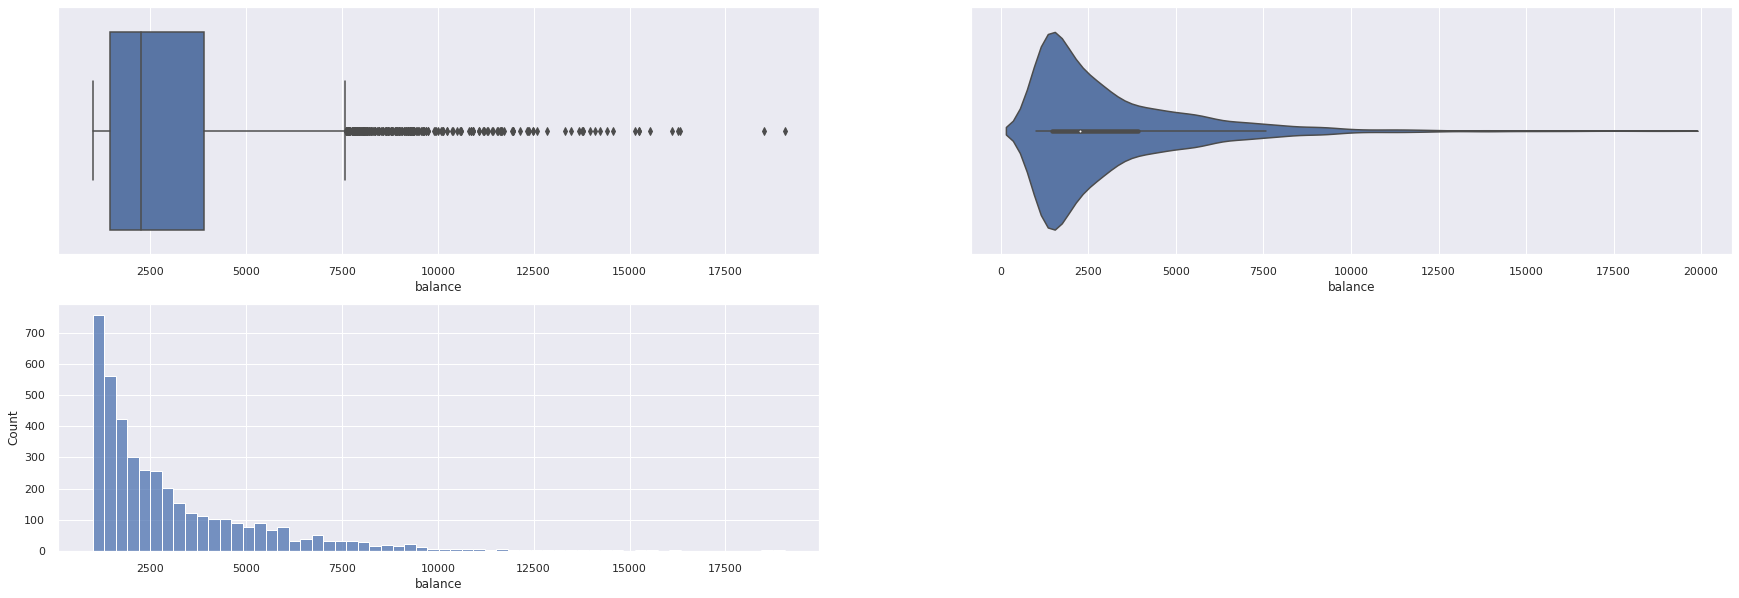

In [42]:
aux= df2.query('balance > 1000')


plt.subplot(2,2,1)
sns.boxplot(x='balance', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='balance', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='balance', data=aux);
# df2.balance.describe()

BALANCE FREQUENCY
- How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

It seems that the customers frequently use their credit card. The customers with not frequently updated balance may be just have the card and use another.

May have outliers

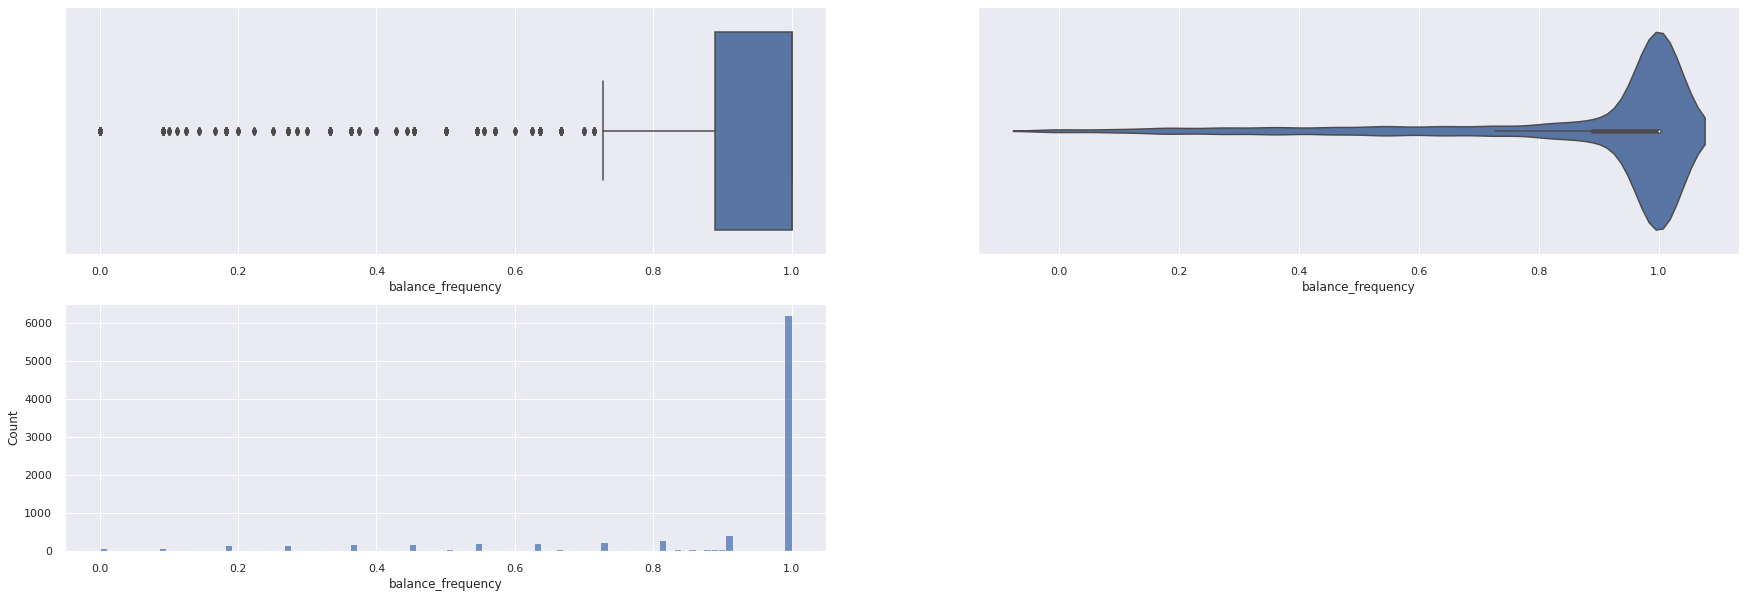

In [43]:
aux= df2#.query('balance < 1.0')


plt.subplot(2,2,1)
sns.boxplot(x='balance_frequency', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='balance_frequency', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='balance_frequency', data=aux);
# df2.balance.describe()

PURCHASES

- Amount of purchases made from account

The customers with high amount of purchases do not seem to be outliers


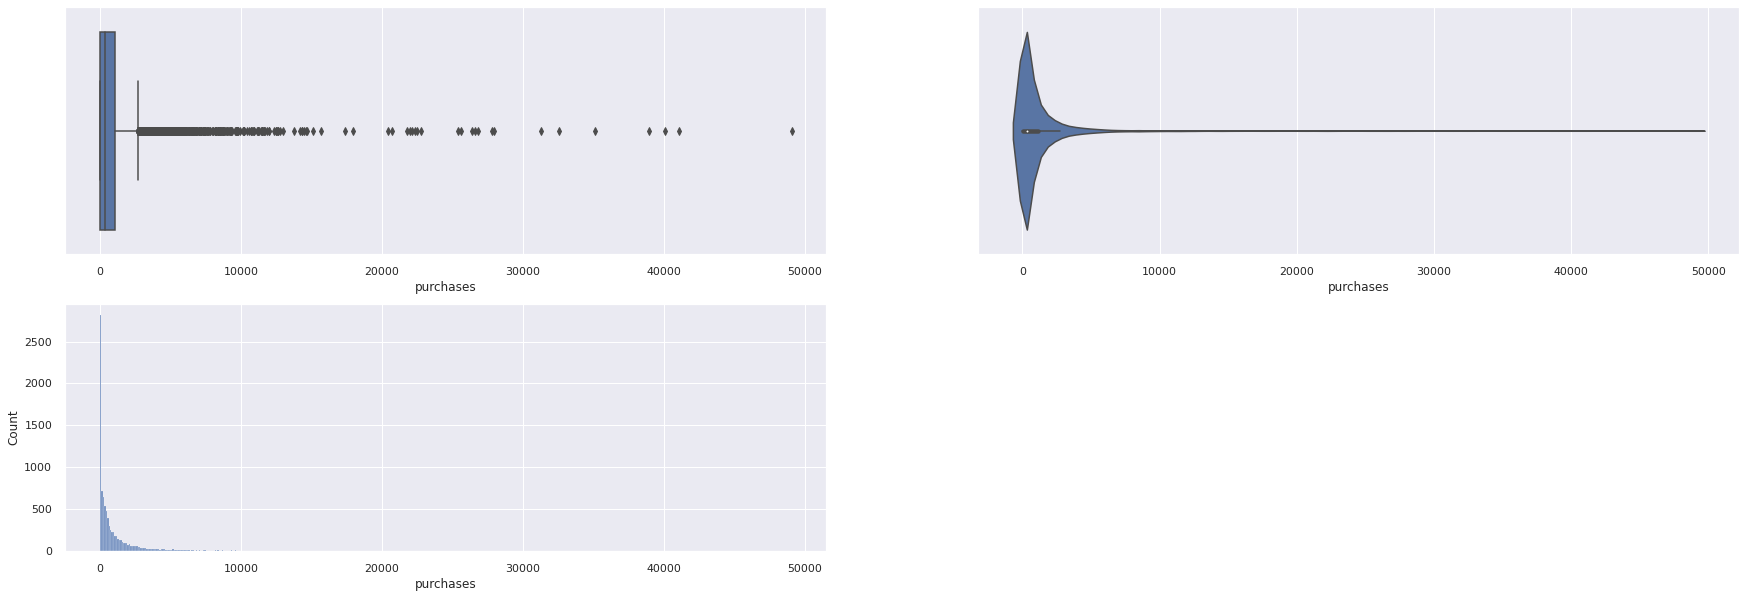

In [44]:
aux= df2#.query('purchases > 10145')


plt.subplot(2,2,1)
sns.boxplot(x='purchases', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='purchases', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='purchases', data=aux);
# df2.purchases.describe()

In [45]:
aux.head()

cust_id      balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit     payments  minimum_payments  prc_full_payment  tenure
0  C10001    40.900749           0.818182      95.40              0.00                    95.4      0.000000             0.166667                    0.000000                          0.083333                0.000000                 0              2        1000.0   201.802084        139.509787          0.000000      12
1  C10002  3202.467416           0.909091       0.00              0.00                     0.0   6442.945483             0.000000                    0.000000                          0.000000                0.250000                 4              0        7000.0  4103.032597       1072.340217          0.222222      12
2  C10003  2495.148862           1.000000     773.17            773.17                     0.0      0.000000             1.000000                    1.000000                          0.000000                0.000000                 0             12        7500.0   622.066742        627.284787          0.000000      12
3  C10004  1666.670542           0.636364    1499.00           1499.00                     0.0    205.788017             0.083333                    0.083333                          0.000000                0.083333                 1              1        7500.0     0.000000          0.000000          0.000000      12
4  C10005   817.714335           1.000000      16.00             16.00                     0.0      0.000000             0.083333                    0.083333                          0.000000                0.000000                 0              1        1200.0   678.334763        244.791237          0.000000      12

ONEOFFPURCHASES

- Maximum purchase amount done in one-go
- The amount, limit and frequency seems right

May have outliers 

count     8949.000000
mean      1564.647593
std       2081.584016
min          0.000000
25%        128.365782
50%        873.680279
75%       2054.372848
max      19043.138560
Name: balance, dtype: float64

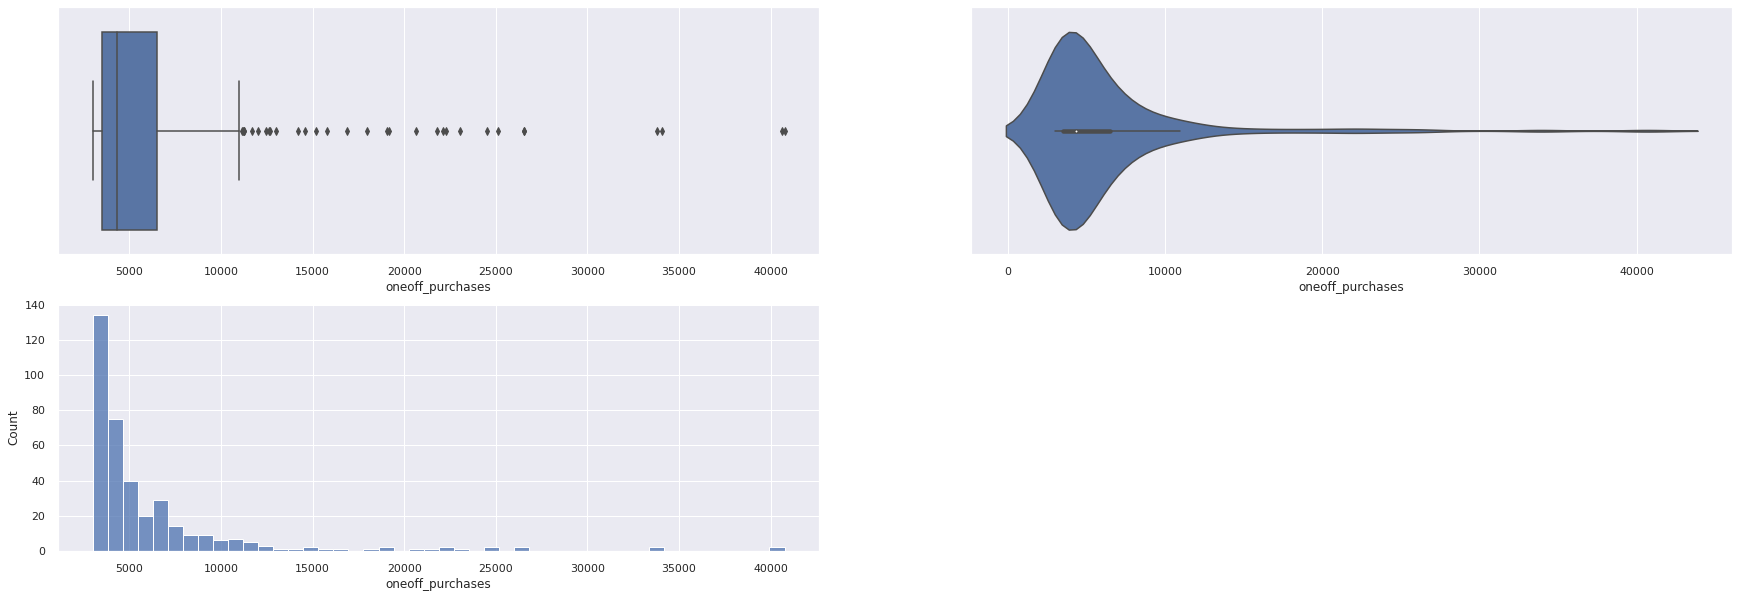

In [46]:
aux= df2.query('oneoff_purchases > 3000')


plt.subplot(2,2,1)
sns.boxplot(x='oneoff_purchases', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='oneoff_purchases', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='oneoff_purchases', data=aux);
df2.balance.describe()

In [47]:
aux.head().round(2)

cust_id  balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  payments  minimum_payments  prc_full_payment  tenure
6   C10007   627.26               1.00    7091.01           6402.63                  688.38          0.00                 1.00                        1.00                              1.00                    0.00                 0             64       13500.0   6354.31            198.07              1.00      12
21  C10022  6369.53               1.00    6359.95           5910.04                  449.91        229.03                 1.00                        0.92                              1.00                    0.33                 6             92       11250.0   2077.96           1659.78              0.00      12
23  C10024  3800.15               0.82    4248.35           3454.56                  793.79       7974.42                 1.00                        0.08                              0.92                    0.33                13             13        9000.0   9479.04           1425.43              0.00      12
57  C10059  2386.33               1.00    5217.62           4789.09                  428.53          0.00                 0.92                        0.92                              0.50                    0.00                 0             42        7500.0   5678.73           1311.51              0.08      12
84  C10088  1935.36               1.00    4915.60           4515.34                  400.26        293.84                 1.00                        1.00                              0.33                    0.08                 1             50        9000.0   4921.07            594.76              0.00      12

In [48]:
df2['oneoff_purchases']=df2['oneoff_purchases'].astype(int)
df2['credit_limit']=df2['credit_limit'].astype(int)

In [49]:
aux10=df2.copy()
aux10['outliers_oneoff_limitcredit'] = np.where(df2['oneoff_purchases'] > df2['credit_limit'], 'possible_outlier', 'normal_user')

In [50]:
aux10.query('outliers_oneoff_limitcredit == "possible_outlier"').round(2).head()

cust_id  balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  payments  minimum_payments  prc_full_payment  tenure outliers_oneoff_limitcredit
125  C10131  2392.92                1.0   12462.44             12462                    0.00          0.00                 0.92                        0.92                              0.00                    0.00                 0            217          2800  11628.72           2000.99              0.00      12            possible_outlier
204  C10212  4559.78                1.0   10848.50              8208                 2640.50          0.00                 1.00                        0.67                              1.00                    0.00                 0            123          7500   9423.72           2925.28              0.00      12            possible_outlier
224  C10233  6571.48                1.0    9325.22              9325                    0.00          0.00                 0.33                        0.33                              0.00                    0.00                 0              5          8500  11036.73           1824.68              0.00      12            possible_outlier
262  C10273  2041.48                1.0    7323.38              4944                 2378.50        191.33                 1.00                        0.83                              0.75                    0.08                 1             81          3000   3792.10           1737.89              0.08      12            possible_outlier
273  C10284  5131.32                1.0   32539.78             26547                 5992.35          0.00                 1.00                        1.00                              1.00                    0.00                 0             98         11500  26652.34           1971.13              0.08      12            possible_outlier

CASHADVANCE 

- The option of take credit money in a ATM
- Studying this feature, the point that caught my attention is the fact that this way of borrowing money from the bank brings a lot of taxes to the customer
- The customers whose used cas in advance have a cash_advance_trx in right way 

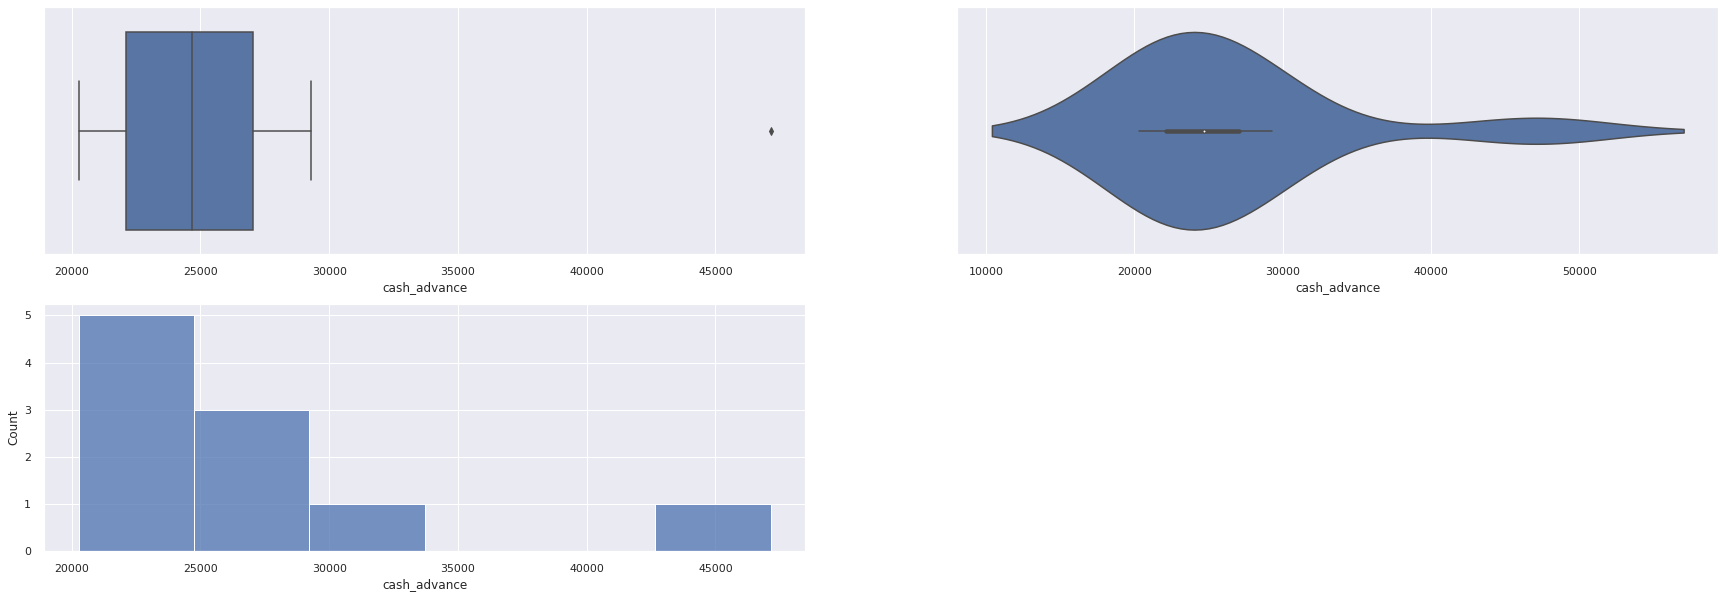

In [51]:
aux= df2.query('cash_advance > 20000')


plt.subplot(2,2,1)
sns.boxplot(x='cash_advance', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='cash_advance', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='cash_advance', data=aux);
# df2.balance.describe()

In [52]:
aux.head()

cust_id       balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit     payments  minimum_payments  prc_full_payment  tenure
71    C10074   2990.422186           0.909091    4523.27              1664                 2859.18   27296.48576             0.666667                        0.50                          0.583333                0.833333                27             33          7000  28232.69446       1107.030803          0.454545      12
883   C10914  14581.459140           1.000000       0.00                 0                    0.00   22665.77850             0.000000                        0.00                          0.000000                0.833333                30              0         18500  20941.32551       5433.759888          0.000000      12
1059  C11094   8823.284205           1.000000    3719.00              2293                 1425.82   29282.10915             1.000000                        0.75                          1.000000                0.416667                26             61         15500  28150.97869       7321.639932          0.083333      12
2159  C12226  10905.053810           1.000000     431.93               133                  298.43   47137.21176             0.583333                        0.25                          0.500000                1.000000               123             21         19600  39048.59762       5394.173671          0.000000      12
2454  C12528  10915.550750           1.000000       0.00                 0                    0.00   23130.82106             0.000000                        0.00                          0.000000                0.583333                23              0         15000  18341.95467       3127.192305          0.000000      12

CASHADVANCETRX
The definitions is not clear

- Number of Transactions made with "Cash in Advanced"
- The customers whose took money are making trx with it

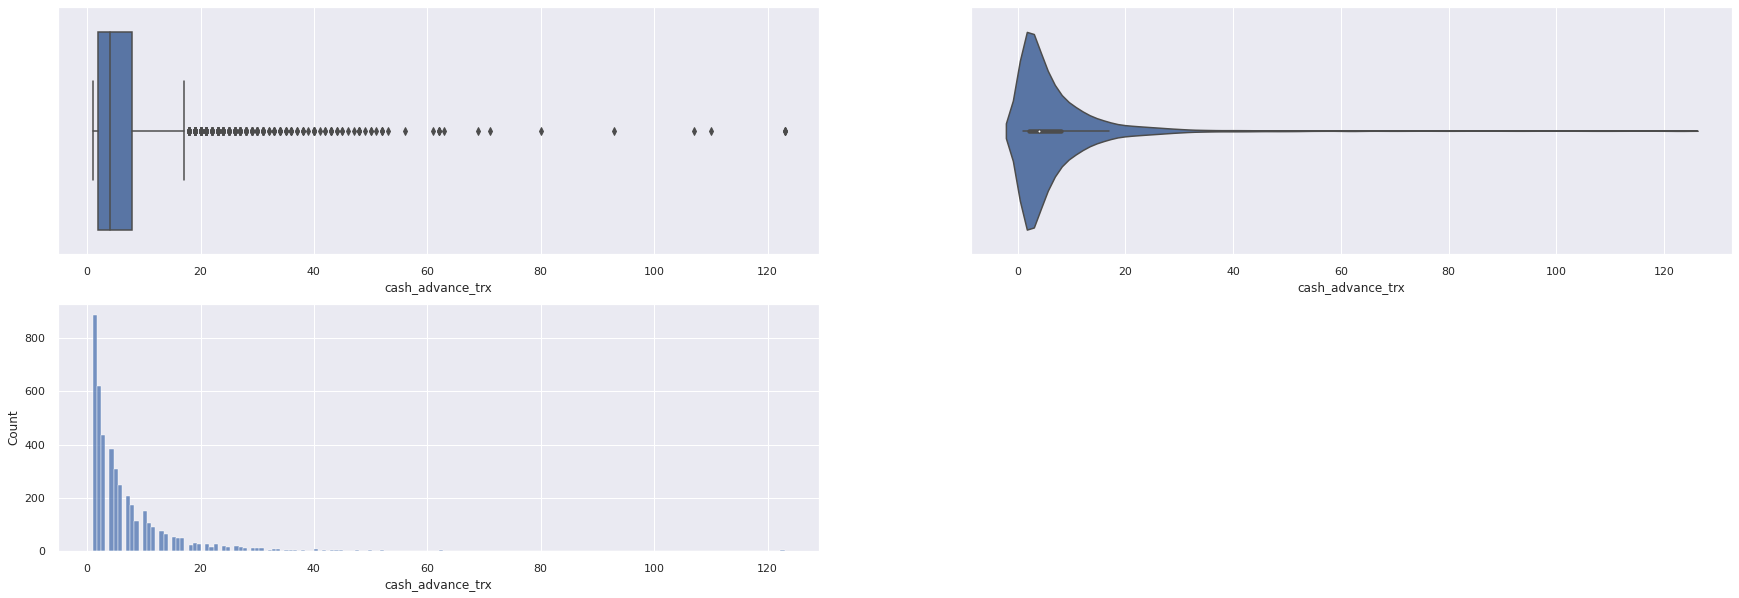

In [53]:
aux= df2.query('cash_advance_trx > 0')


plt.subplot(2,2,1)
sns.boxplot(x='cash_advance_trx', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='cash_advance_trx', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='cash_advance_trx', data=aux);
# df2.balance.describe()

PURCHASESTRX

- Number of purchase transactions made


May have outliers

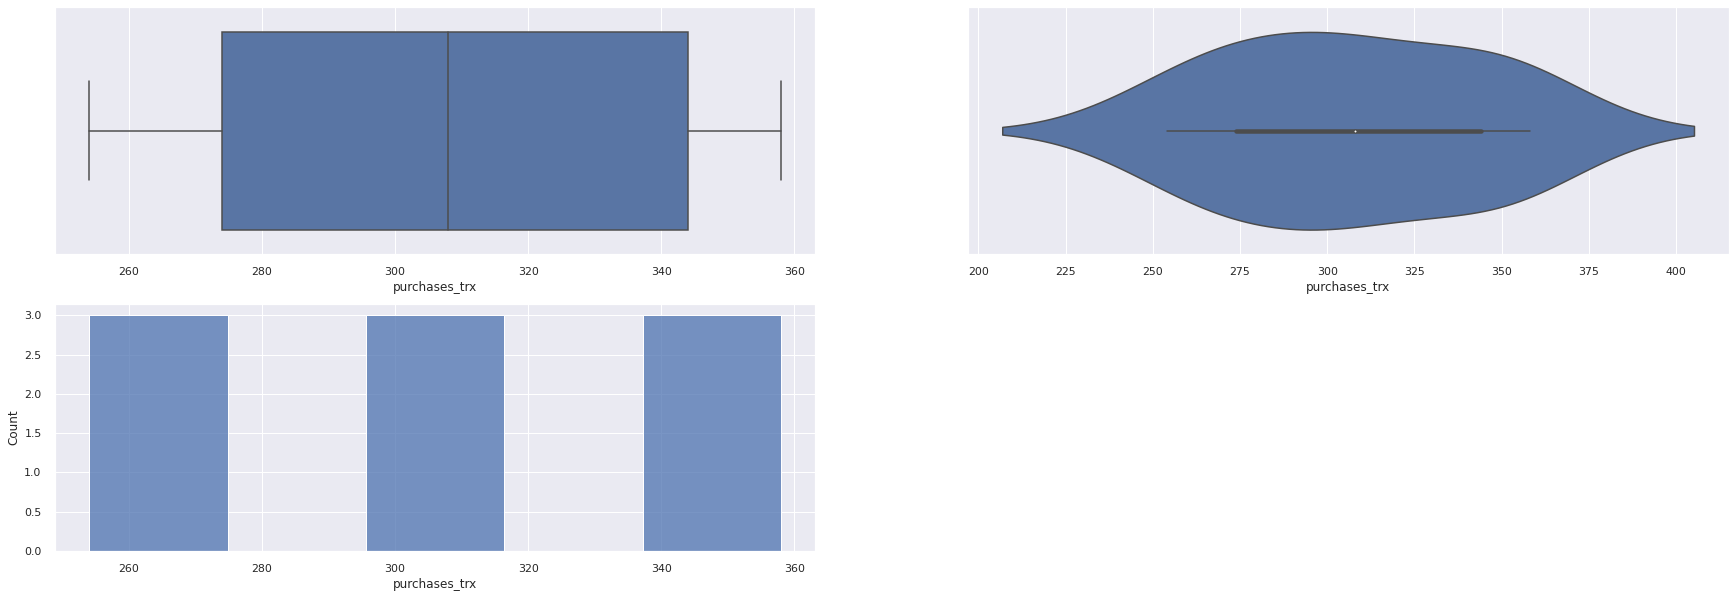

In [54]:
aux= df2.query('purchases_trx > 250')


plt.subplot(2,2,1)
sns.boxplot(x='purchases_trx', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='purchases_trx', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='purchases_trx', data=aux);
# df2.balance.describe()

In [55]:
aux.head().round(2)

cust_id   balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  payments  minimum_payments  prc_full_payment  tenure
1256  C11300   4010.62                1.0   40040.71             24543                15497.19          0.00                  1.0                        1.00                               1.0                    0.00                 0            358         18000  33994.73            703.50              1.00      12
1912  C11974   5292.91                1.0    5539.68              2603                 2935.89          0.00                  1.0                        0.92                               1.0                    0.00                 0            273          6000   3597.68           3838.48              0.00      12
2515  C12589   3891.35                1.0    3629.80                50                 3579.80       2538.56                  1.0                        0.08                               1.0                    0.17                 5            254          7500   8259.41           4725.47              0.08      12
2823  C12905  11642.60                1.0   15108.47              2370                12738.47          0.00                  1.0                        0.50                               1.0                    0.00                 0            298         12000  16005.45          11652.57              0.00      12
3181  C13272  11631.32                1.0   14686.10                 0                14686.10       3422.72                  1.0                        0.00                               1.0                    0.08                 2            347         13600  11400.60          10285.13              0.00      12

CREDITLIMIT

- Limit of Credit Card for user


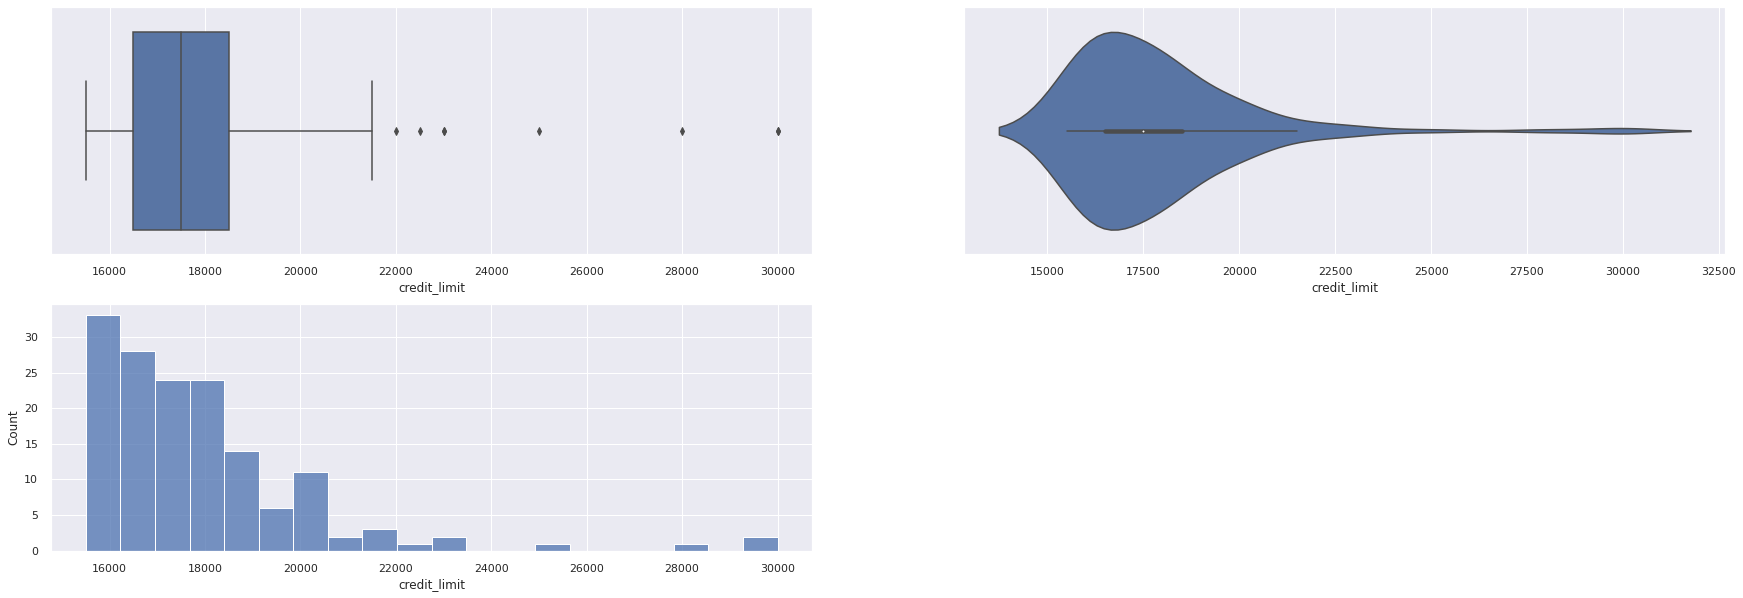

In [56]:
aux= df2.query('credit_limit > 15000')


plt.subplot(2,2,1)
sns.boxplot(x='credit_limit', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='credit_limit', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='credit_limit', data=aux);
# df2.balance.describe()

PAYMENTS

- Amount of Payment done by user


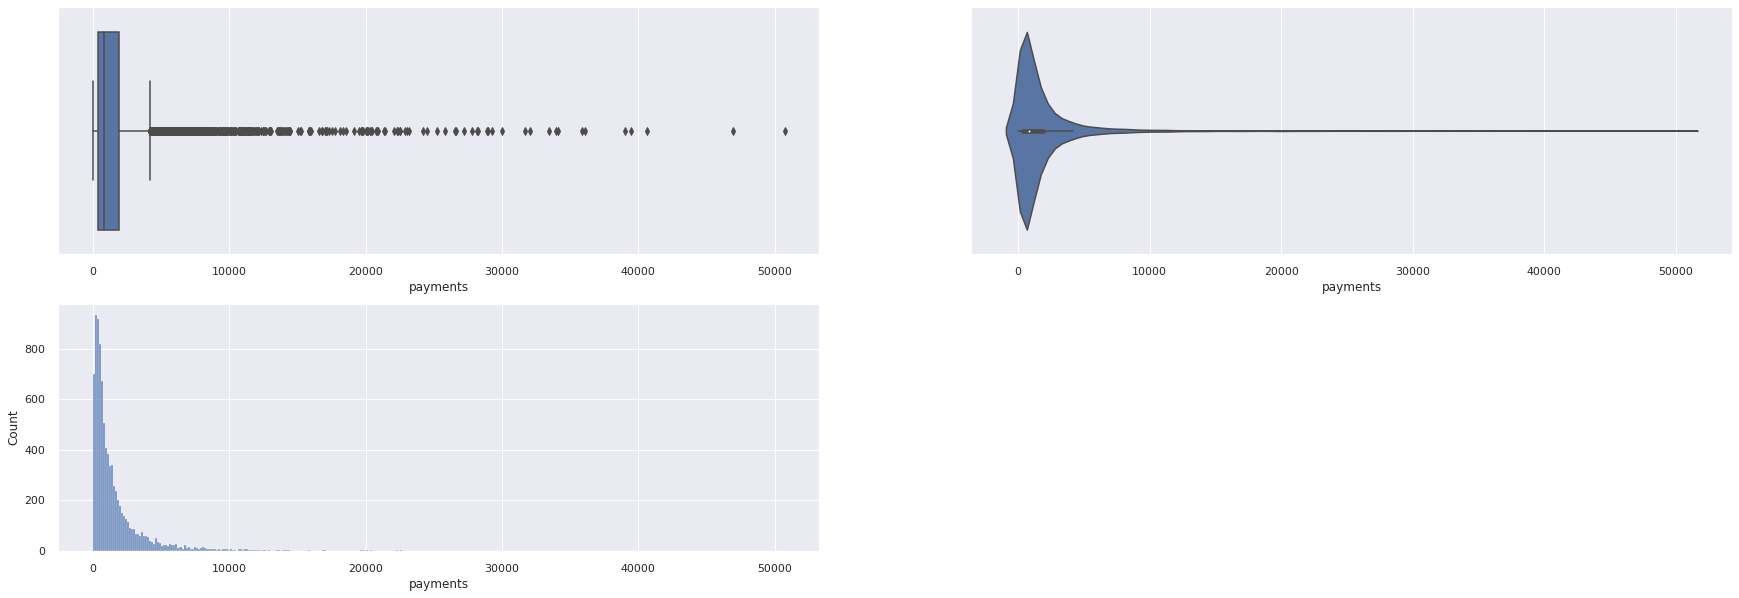

In [57]:
aux= df2#.query('oneoff_payment = 0')


plt.subplot(2,2,1)
sns.boxplot(x='payments', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='payments', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='payments', data=aux);
# df2.balance.describe()

MINIMUM_PAYMENTS

- Minimum amount of payments made by user

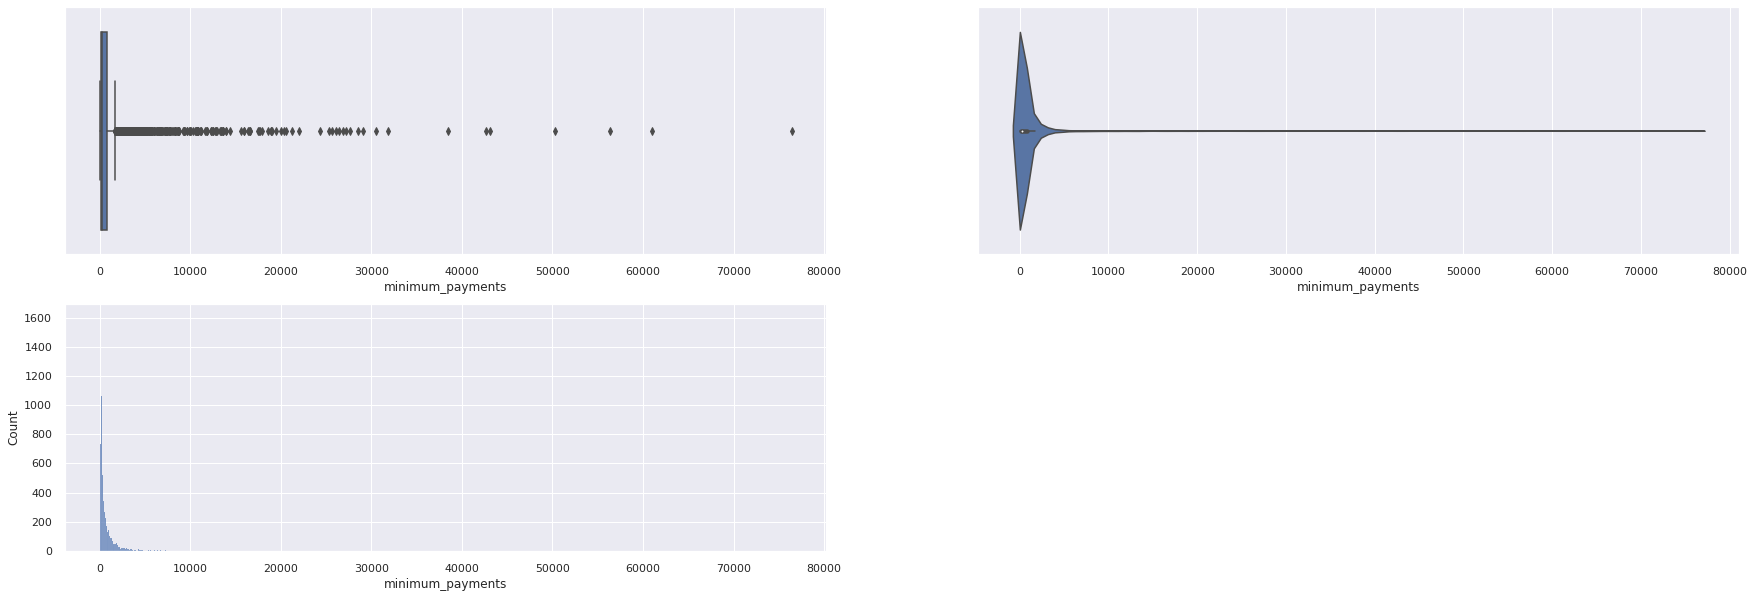

In [58]:
aux= df2#.query('minimum_payments > 250')


plt.subplot(2,2,1)
sns.boxplot(x='minimum_payments', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='minimum_payments', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='minimum_payments', data=aux);
# df2.balance.describe()

PRCFULLPAYMENT

- Percent of full payment paid by user

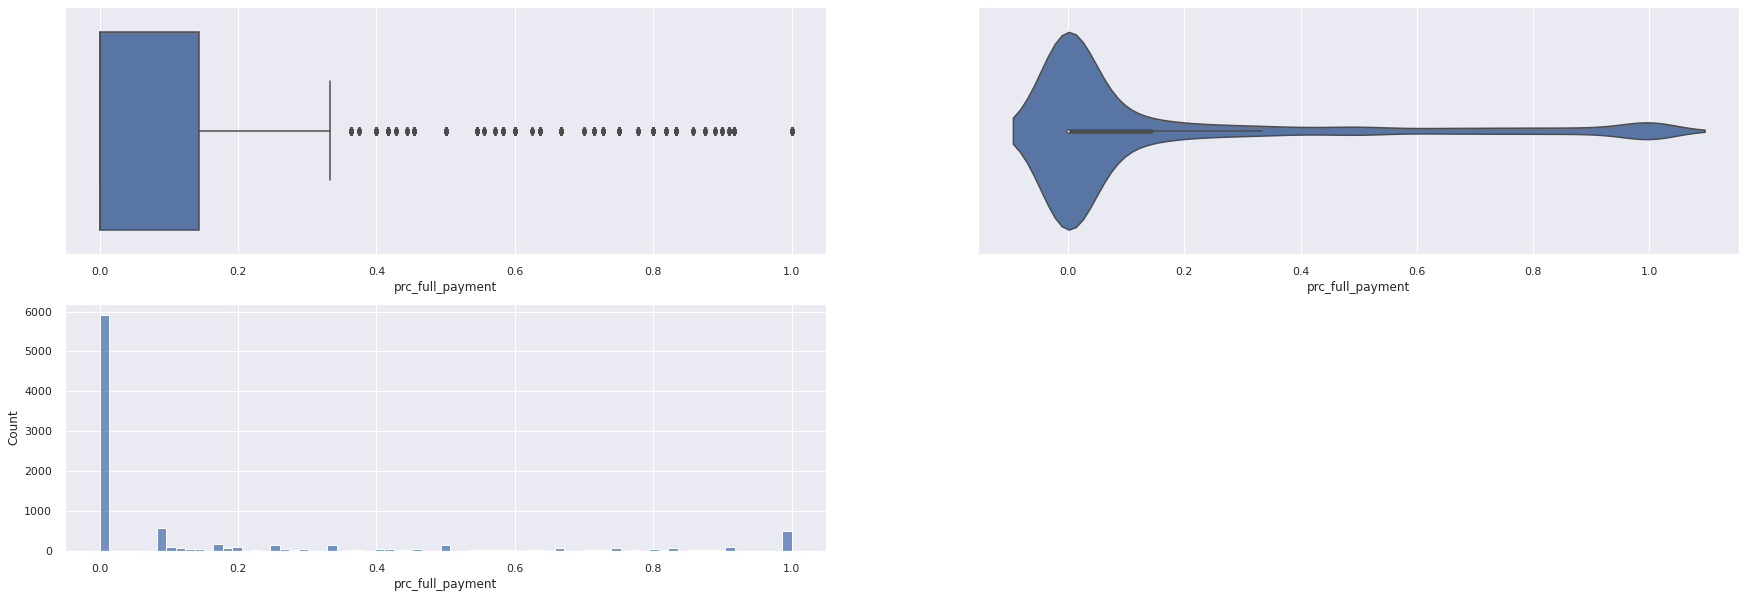

In [59]:
aux= df2#.query('minimum_payments > 250')


plt.subplot(2,2,1)
sns.boxplot(x='prc_full_payment', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='prc_full_payment', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='prc_full_payment', data=aux);
# df2.balance.describe()

General Histograms

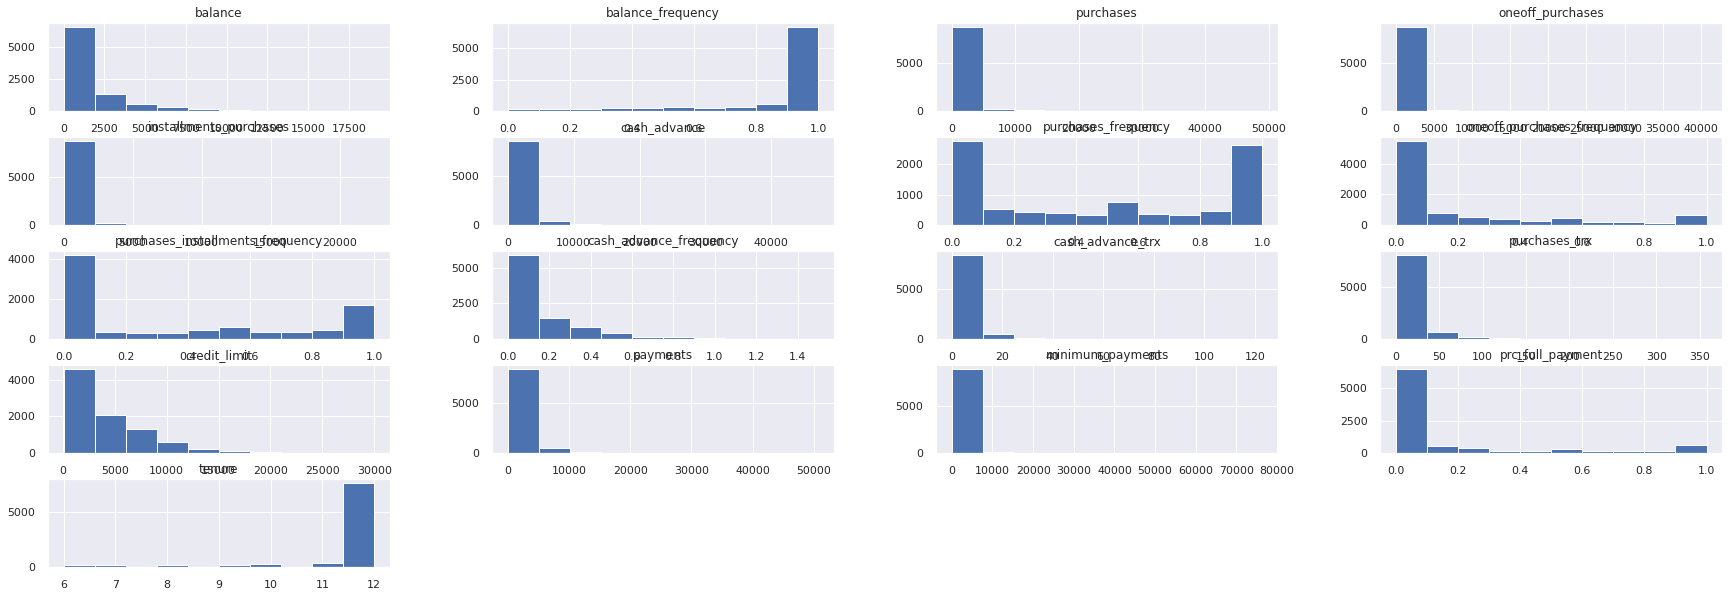

In [60]:
df1_num.hist();

In [61]:
# sns.pairplot(df1);

## 2.3 Multivariate Analysis

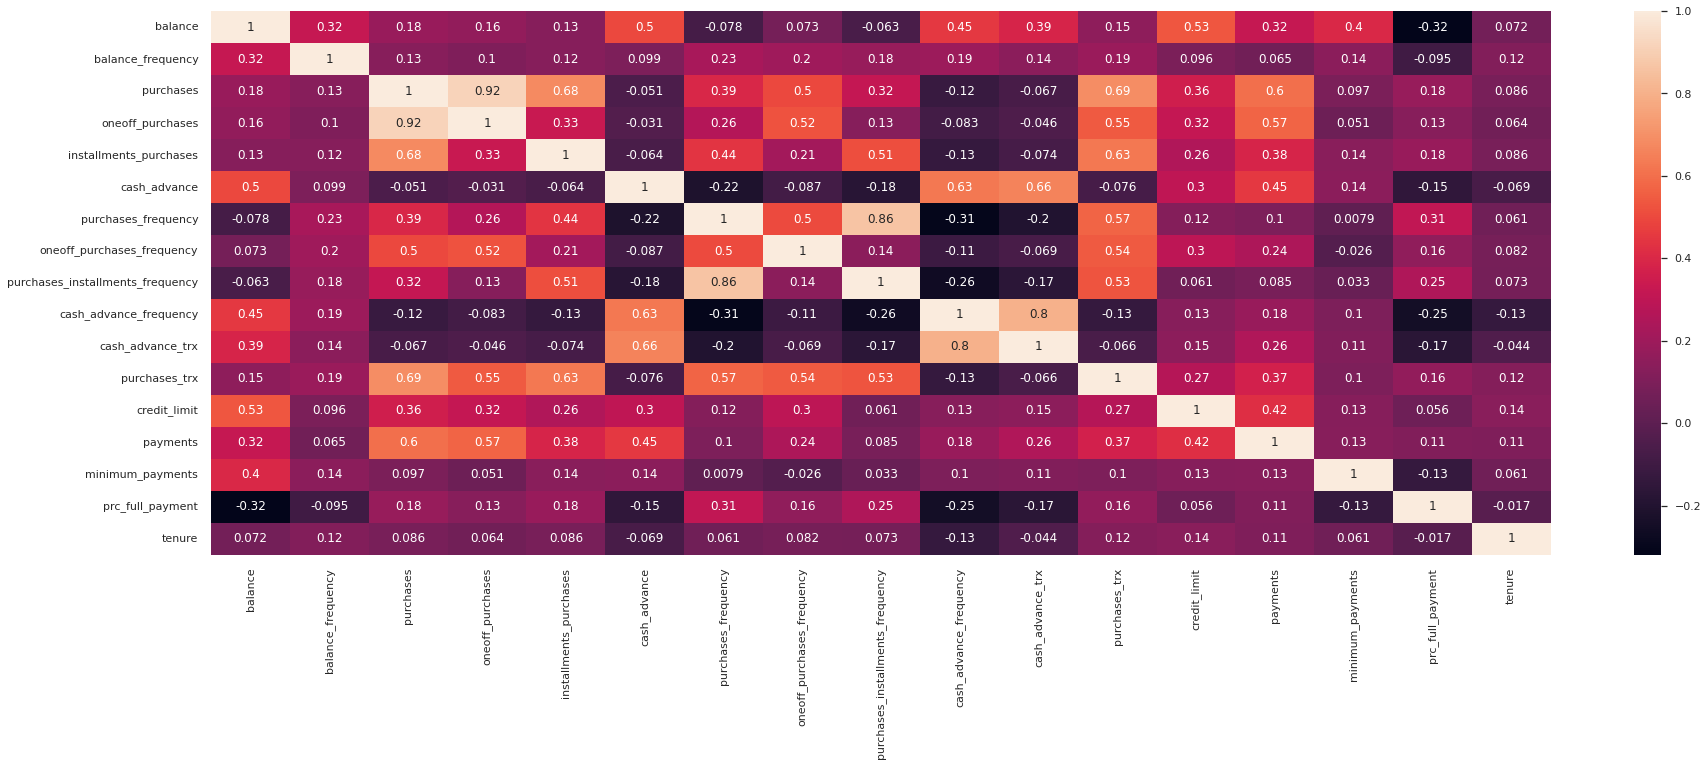

In [62]:
aux=df2.drop(columns=['cust_id'],axis=1)
sns.heatmap(aux.corr( method='pearson' ), annot=True );

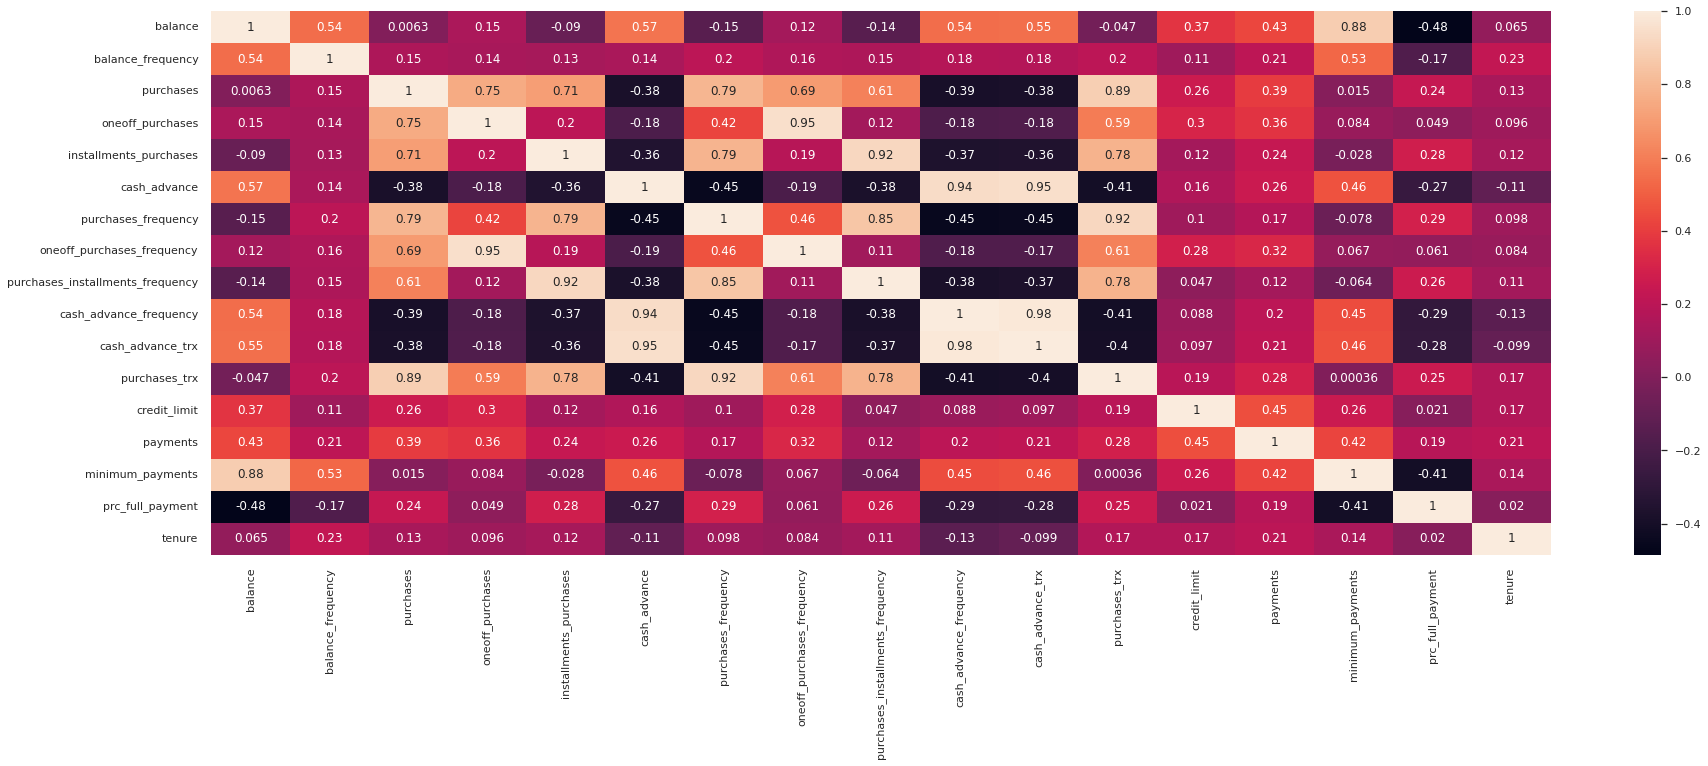

In [63]:
sns.heatmap(aux.corr( method='spearman' ), annot=True );

# 3.0 Data Filtering

In [64]:
df3=df2.copy()

# ['purchases_installments_frequency', 'tenure', 'cash_advance_frequency']

# 4.0 Feature Engineering

In [65]:
df4=df3.copy()

In [66]:
df4.head().round(2)

cust_id  balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  payments  minimum_payments  prc_full_payment  tenure
0  C10001    40.90               0.82      95.40                 0                    95.4          0.00                 0.17                        0.00                              0.08                    0.00                 0              2          1000    201.80            139.51              0.00      12
1  C10002  3202.47               0.91       0.00                 0                     0.0       6442.95                 0.00                        0.00                              0.00                    0.25                 4              0          7000   4103.03           1072.34              0.22      12
2  C10003  2495.15               1.00     773.17               773                     0.0          0.00                 1.00                        1.00                              0.00                    0.00                 0             12          7500    622.07            627.28              0.00      12
3  C10004  1666.67               0.64    1499.00              1499                     0.0        205.79                 0.08                        0.08                              0.00                    0.08                 1              1          7500      0.00              0.00              0.00      12
4  C10005   817.71               1.00      16.00                16                     0.0          0.00                 0.08                        0.08                              0.00                    0.00                 0              1          1200    678.33            244.79              0.00      12

In [67]:
df40=df4.copy()


# ============================================================================
# totaltrx_avg_ticket
# purchase_avg_ticket
# ============================================================================



# test with and withou the tenure derivations

# credit_limit by tenure
df40['cred_tenure']=df40['credit_limit']/df40['tenure']
df40['purchase_tenure']=df40['purchases']/df40['tenure']

df40['balance_tenure']=df40['balance']/df40['tenure']
df40['balancefreq_tenure']=df40['balance_frequency']/df40['tenure']

# purchase avg ticket
# df40['purchase_avg_ticket']=df40['purchases']/df40['purchases_trx']

# one go payments yes or no (delete )
df40['onego']=df40.oneoff_purchases.apply( lambda x:  0 if x==0.00 else 1)

# total spending(ATM + passing CCard) / trx total purchase
# df40['totaltrx_avg_ticket']=(df40['purchases']+df40['cash_advance']) / (df40['purchases_trx']+df40['cash_advance_trx'])

# debt rate payment
df40['debt_rate']=(df40['purchases']+df40['cash_advance']) / (df40['payments']+df40['minimum_payments'])

# limit cc freq
df40['credit_limit_rate']=df40['purchases']+df40['cash_advance'] / (6*df40['credit_limit'])

df40=df40.fillna(0)



In [68]:
asd

NameError: name 'asd' is not defined

## 4.1 Isolation Forest

/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


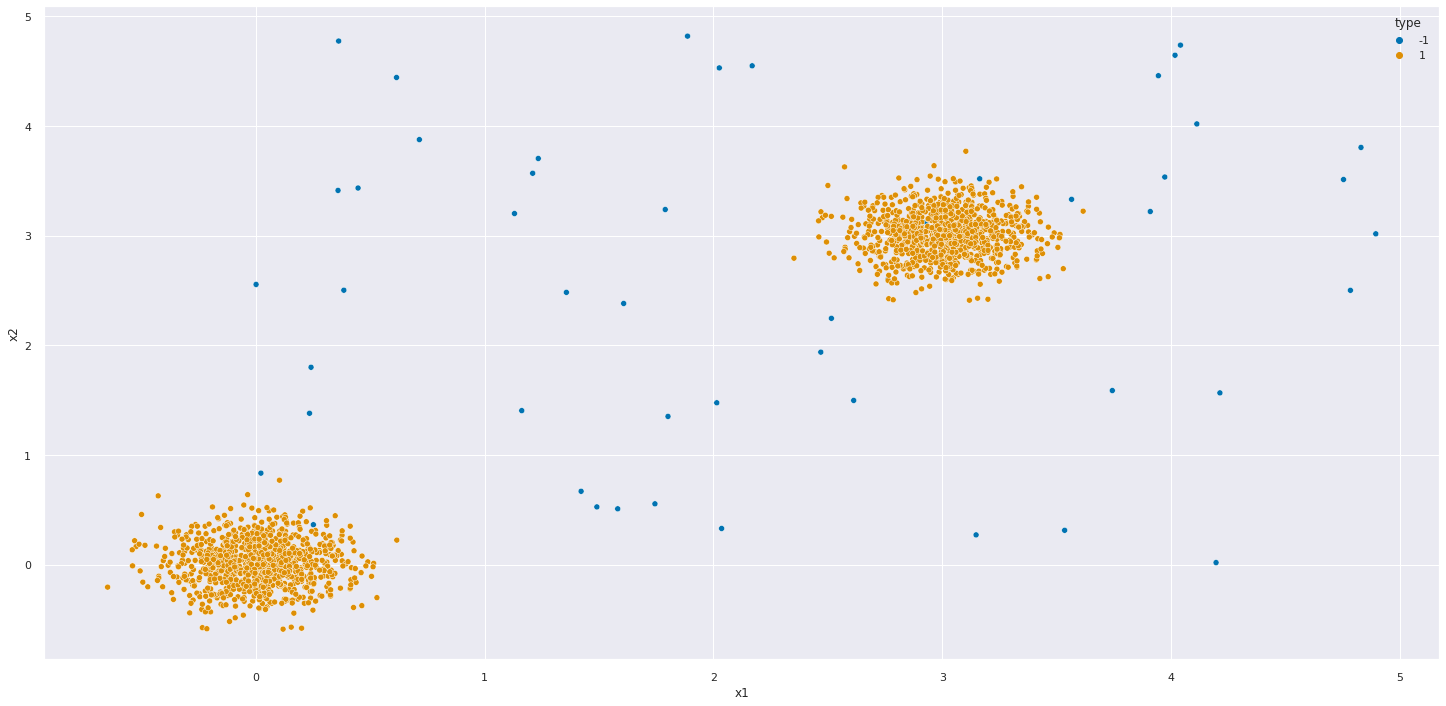

In [ ]:
rng = np.random.RandomState(42)

# generating training data
X= 0.2*rng.randn(1000, 2)


# check r_
X=np.r_[X+3, X]
X = pd.DataFrame(X, columns=['x1', 'x2'])
X['type'] = 1

# noise data(outliers)
X_outliers=rng.uniform(low=0, high=5, size=(50,2))
X_outliers=pd.DataFrame(X_outliers, columns=['x1', 'x2'])
X_outliers['type'] = -1

X = pd.concat([X_outliers,X])

sns.scatterplot('x1', 'x2', palette='colorblind',hue='type', data=X);

/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


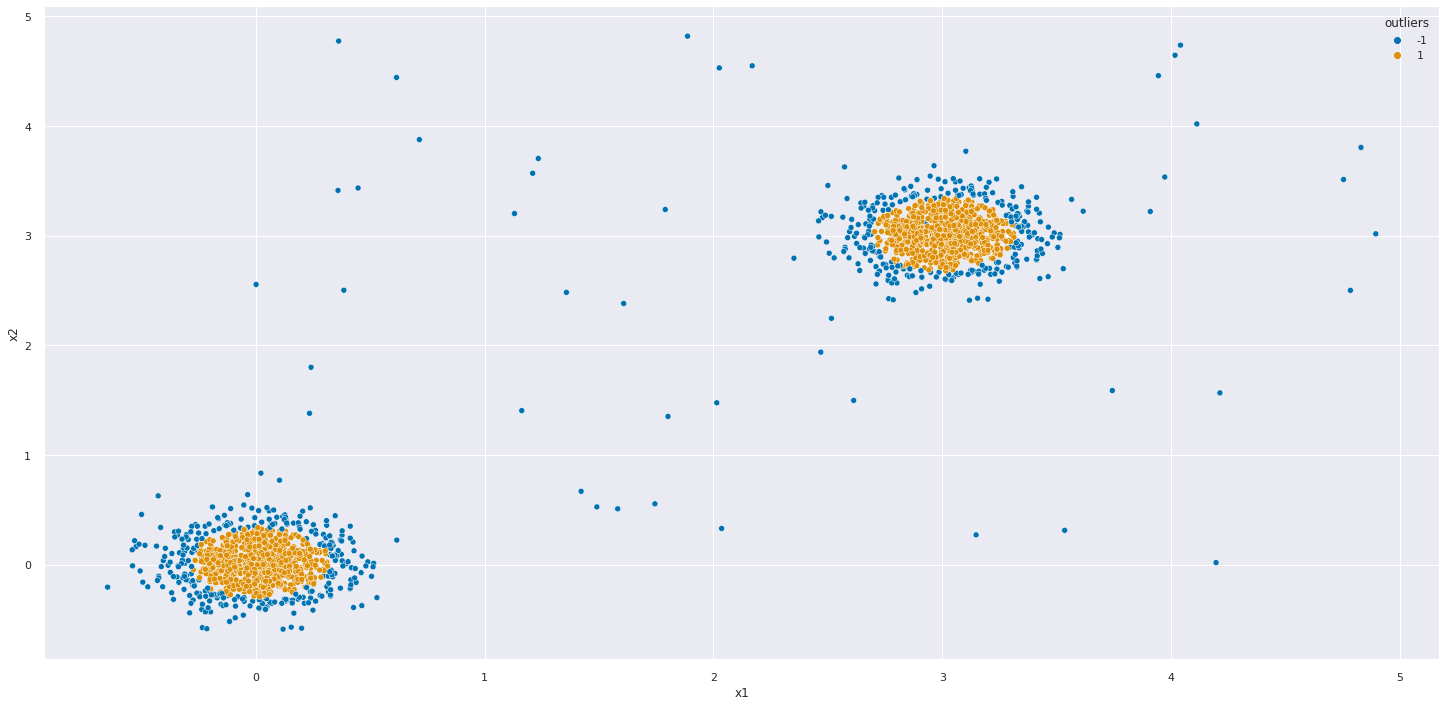

In [ ]:
df= X.drop('type', axis=1)


# isolation forest
from sklearn import ensemble as en
# train
iso_model=en.IsolationForest(n_estimators=1300, max_samples=300, bootstrap=True, contamination=0.30, random_state=rng, n_jobs=-1)


# predict
preds = iso_model.fit_predict(X)

# performance
X['outliers']=preds

sns.scatterplot('x1', 'x2', hue='outliers', palette='colorblind', data=X);

## 4.2 PyOD with KNN

In [73]:
df4.head()

cust_id      balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit     payments  minimum_payments  prc_full_payment  tenure
0  C10001    40.900749           0.818182      95.40                 0                    95.4      0.000000             0.166667                    0.000000                          0.083333                0.000000                 0              2          1000   201.802084        139.509787          0.000000      12
1  C10002  3202.467416           0.909091       0.00                 0                     0.0   6442.945483             0.000000                    0.000000                          0.000000                0.250000                 4              0          7000  4103.032597       1072.340217          0.222222      12
2  C10003  2495.148862           1.000000     773.17               773                     0.0      0.000000             1.000000                    1.000000                          0.000000                0.000000                 0             12          7500   622.066742        627.284787          0.000000      12
3  C10004  1666.670542           0.636364    1499.00              1499                     0.0    205.788017             0.083333                    0.083333                          0.000000                0.083333                 1              1          7500     0.000000          0.000000          0.000000      12
4  C10005   817.714335           1.000000      16.00                16                     0.0      0.000000             0.083333                    0.083333                          0.000000                0.000000                 0              1          1200   678.334763        244.791237          0.000000      12

In [77]:
df4.iloc[:, 1:].head()

balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit     payments  minimum_payments  prc_full_payment  tenure
0    40.900749           0.818182      95.40                 0                    95.4      0.000000             0.166667                    0.000000                          0.083333                0.000000                 0              2          1000   201.802084        139.509787          0.000000      12
1  3202.467416           0.909091       0.00                 0                     0.0   6442.945483             0.000000                    0.000000                          0.000000                0.250000                 4              0          7000  4103.032597       1072.340217          0.222222      12
2  2495.148862           1.000000     773.17               773                     0.0      0.000000             1.000000                    1.000000                          0.000000                0.000000                 0             12          7500   622.066742        627.284787          0.000000      12
3  1666.670542           0.636364    1499.00              1499                     0.0    205.788017             0.083333                    0.083333                          0.000000                0.083333                 1              1          7500     0.000000          0.000000          0.000000      12
4   817.714335           1.000000      16.00                16                     0.0      0.000000             0.083333                    0.083333                          0.000000                0.000000                 0              1          1200   678.334763        244.791237          0.000000      12

In [78]:
detector=KNN()
detector.fit(df4.iloc[:, 1:])

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [80]:
previsoes=detector.labels_
np.unique(previsoes, return_counts=True)

(array([0, 1]), array([8054,  895]))

In [83]:
confianca_previsoes=detector.decision_scores_
confianca_previsoes.max()

36093.88386936779

In [86]:
outliers=[]

for i in range(len(previsoes)):
    if previsoes[i] == 1:
        outliers.append(i)

In [89]:
print(outliers)

[6, 19, 21, 23, 30, 34, 39, 50, 71, 86, 87, 90, 102, 109, 112, 120, 122, 124, 125, 128, 133, 136, 138, 143, 150, 153, 155, 156, 158, 167, 171, 174, 178, 182, 193, 195, 200, 203, 204, 220, 223, 224, 229, 231, 240, 248, 249, 258, 262, 263, 265, 269, 273, 274, 280, 295, 301, 302, 304, 312, 326, 339, 341, 348, 351, 352, 363, 367, 369, 370, 376, 380, 387, 393, 409, 416, 417, 423, 430, 435, 441, 445, 452, 453, 459, 468, 470, 475, 477, 482, 484, 485, 491, 492, 495, 501, 507, 511, 512, 517, 519, 520, 521, 526, 527, 535, 536, 537, 539, 544, 546, 548, 550, 551, 552, 554, 560, 563, 565, 567, 569, 571, 574, 584, 585, 587, 589, 591, 602, 610, 616, 619, 620, 622, 624, 628, 634, 637, 643, 644, 645, 647, 652, 655, 658, 662, 666, 669, 679, 684, 697, 708, 709, 710, 716, 723, 725, 726, 733, 739, 750, 756, 769, 776, 780, 782, 789, 800, 801, 802, 810, 824, 842, 843, 844, 851, 853, 854, 856, 857, 866, 871, 873, 883, 884, 886, 891, 893, 898, 903, 916, 919, 922, 933, 938, 939, 941, 970, 981, 982, 984, 987, 10

In [90]:
lista_outliers = df4.iloc[outliers, :]
lista_outliers.head()

cust_id       balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit     payments  minimum_payments  prc_full_payment  tenure
6   C10007    627.260806           1.000000    7091.01              6402                  688.38      0.000000                  1.0                    1.000000                          1.000000                0.000000                 0             64         13500  6354.314328        198.065894               1.0      12
19  C10020   3577.970933           1.000000     398.64                 0                  398.64      0.000000                  1.0                    0.000000                          1.000000                0.000000                 0             12          4000  1053.980464      12465.549380               0.0      12
21  C10022   6369.531318           1.000000    6359.95              5910                  449.91    229.028245                  1.0                    0.916667                          1.000000                0.333333                 6             92         11250  2077.959051       1659.775075               0.0      12
23  C10024   3800.151377           0.818182    4248.35              3454                  793.79   7974.415626                  1.0                    0.083333                          0.916667                0.333333                13             13          9000  9479.043842       1425.426525               0.0      12
30  C10031  12136.219960           1.000000    3038.01              1013                 2024.81   3183.583301                  1.0                    0.166667                          1.000000                0.500000                10             64         13000  4230.323491       3292.015030               0.0      12

# 5.0 Data preparation

In [ ]:
df5=df4.copy()
df50=df40.copy()

In [ ]:
df5.head()

cust_id      balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit     payments  minimum_payments  prc_full_payment  tenure
0  C10001    40.900749           0.818182      95.40                 0                   95.40      0.000000             0.166667                    0.000000                          0.083333                    0.00                 0              2          1000   201.802084        139.509787          0.000000      12
1  C10002  3202.467416           0.909091       0.00                 0                    0.00   6442.945483             0.000000                    0.000000                          0.000000                    0.25                 4              0          7000  4103.032597       1072.340217          0.222222      12
2  C10003  2495.148862           1.000000     773.17               773                    0.00      0.000000             1.000000                    1.000000                          0.000000                    0.00                 0             12          7500   622.066742        627.284787          0.000000      12
4  C10005   817.714335           1.000000      16.00                16                    0.00      0.000000             0.083333                    0.083333                          0.000000                    0.00                 0              1          1200   678.334763        244.791237          0.000000      12
5  C10006  1809.828751           1.000000    1333.28                 0                 1333.28      0.000000             0.666667                    0.000000                          0.583333                    0.00                 0              8          1800  1400.057770       2407.246035          0.000000      12

## 5.1 Rescaling

In [ ]:
# base 
mm= MinMaxScaler()

df5['balance']=mm.fit_transform(df5[['balance']])
df5['purchases']=mm.fit_transform(df5[['purchases']])
df5['oneoff_purchases']=mm.fit_transform(df5[['oneoff_purchases']])
df5['installments_purchases']=mm.fit_transform(df5[['installments_purchases']])
df5['cash_advance']=mm.fit_transform(df5[['cash_advance']])
df5['cash_advance_trx']=mm.fit_transform(df5[['cash_advance_trx']])
df5['purchases_trx']=mm.fit_transform(df5[['purchases_trx']])
df5['credit_limit']=mm.fit_transform(df5[['credit_limit']])
df5['payments']=mm.fit_transform(df5[['payments']])
df5['minimum_payments']=mm.fit_transform(df5[['minimum_payments']])
df5['tenure']=mm.fit_transform(df5[['tenure']])




In [ ]:
df5.columns

Index(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure'],
      dtype='object')

In [ ]:
df50['balance']=mm.fit_transform(df50[['balance']])
df50['purchases']=mm.fit_transform(df50[['purchases']])
df50['oneoff_purchases']=mm.fit_transform(df50[['oneoff_purchases']])
df50['installments_purchases']=mm.fit_transform(df50[['installments_purchases']])
df50['cash_advance']=mm.fit_transform(df50[['cash_advance']])
df50['cash_advance_trx']=mm.fit_transform(df50[['cash_advance_trx']])
df50['purchases_trx']=mm.fit_transform(df50[['purchases_trx']])
df50['credit_limit']=mm.fit_transform(df50[['credit_limit']])
df50['payments']=mm.fit_transform(df50[['payments']])
df50['minimum_payments']=mm.fit_transform(df50[['minimum_payments']])
df50['tenure']=mm.fit_transform(df50[['tenure']])
df50['prc_full_payment']=mm.fit_transform(df50[['prc_full_payment']])
df50['cred_tenure']=mm.fit_transform(df50[['cred_tenure']])
df50['purchase_tenure']=mm.fit_transform(df50[['purchase_tenure']])
df50['balance_tenure']=mm.fit_transform(df50[['balance_tenure']])
df50['balancefreq_tenure']=mm.fit_transform(df50[['balancefreq_tenure']])
df50['onego']=mm.fit_transform(df50[['onego']])
df50['debt_rate']=mm.fit_transform(df50[['debt_rate']])
df50['credit_limit_rate']=mm.fit_transform(df50[['credit_limit_rate']])

# totaltrx_avg_ticket
# purchase_avg_ticket

# 'balance', 'purchases','oneoff_purchases', 'installments_purchases', 'cash_advance',
#  'cash_advance_frequency',
#        'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
#        'minimum_payments', 'prc_full_payment', 'tenure', 'cred_tenure',
#        'purchase_tenure', 'balance_tenure', 'balancefreq_tenure',
#        'purchase_avg_ticket', 'onego', 'totaltrx_avg_ticket', 'debt_rate',
#        'credit_limit_rate'

In [ ]:
aux_1=df50.select_dtypes(['float64', 'int64'])
descriptive_statistics(aux_1)

min           max         range         mean      median          std       skew     kurtosis     shapiro
balance                                0.0   19043.13856   19043.13856  1601.224893  916.855459  2095.449969   2.374254     7.553876  not normal
balance_frequency                      0.0           1.0           1.0     0.895035         1.0     0.207685  -2.084161     3.369586  not normal
purchases                              0.0      49039.57      49039.57  1025.433874     375.405  2166.982511   8.055789   108.677684  not normal
oneoff_purchases                       0.0       40761.0       40761.0   604.687934        44.5  1684.120557   9.936975   160.150857  not normal
installments_purchases                 0.0       22500.0       22500.0   420.843533      94.785   917.192075   7.216133    94.193373  not normal
cash_advance                           0.0   47137.21176   47137.21176   994.175523         0.0  2121.335473   5.139629    52.143523  not normal
purchases_frequency                    0.0           1.0           1.0        0.496         0.5     0.401249   0.033041    -1.638001  not normal
oneoff_purchases_frequency             0.0           1.0           1.0     0.205909    0.083333     0.300036   1.504234     1.058206  not normal
purchases_installments_frequency       0.0           1.0           1.0      0.36882    0.166667      0.39807   0.487753    -1.419279  not normal
cash_advance_frequency                 0.0           1.5           1.5     0.137604         0.0      0.20178   1.795915     3.184233  not normal
cash_advance_trx                       0.0         123.0         123.0     3.313918         0.0     6.912106   5.673327    60.428523  not normal
purchases_trx                          0.0         358.0         358.0    15.033233         7.0     25.17901   4.578418    33.952279  not normal
credit_limit                          50.0       30000.0       29950.0  4522.090551      3000.0  3659.028469   1.507019     2.773474  not normal
payments                          0.049513   50721.48336  50721.433847  1784.478099  896.675701  2909.641616   5.873049    54.270814  not normal
minimum_payments                  0.019163   76406.20752  76406.188357   864.304943  312.452292  2372.428981  13.622193   283.963042  not normal
prc_full_payment                       0.0           1.0           1.0     0.159304         0.0     0.296254   1.886027     2.201598  not normal
tenure                                 6.0          12.0           6.0    11.534391        12.0     1.310908  -3.011141     8.156701  not normal
cred_tenure                       4.166667   3333.333333   3329.166667   392.573981  291.666667   318.286111   1.678832     4.305541  not normal
purchase_tenure                        0.0   4086.630833   4086.630833    88.015149     33.2125   183.032863    7.92258   105.270373  not normal
balance_tenure                         0.0   1907.278237   1907.278237   139.547753   80.293311   182.890293   2.434249     8.291047  not normal
balancefreq_tenure                     0.0      0.166667      0.166667     0.078879    0.083333     0.021849  -0.172256     3.903852  not normal
onego                                  0.0           1.0           1.0      0.52258         1.0      0.49949  -0.090428    -1.992284  not normal
debt_rate                              0.0     95.242586     95.242586     0.954868    0.755472     1.413804  35.885235  2298.777804  not normal
credit_limit_rate                      0.0  49039.574135  49039.574135  1025.475987  375.460004  2166.972069   8.055872    108.67934  not normal

# 6.0 Feature Selection

In [ ]:
df6=df5.copy()
X = df6.drop(columns=['cust_id'],axis=1)

df60=df50[['balance', 'purchases','oneoff_purchases', 'installments_purchases', 'cash_advance', 'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure', 'cred_tenure', 'purchase_tenure', 'balance_tenure', 'balancefreq_tenure', 'onego', 'debt_rate', 'credit_limit_rate']]
df6.head()

cust_id   balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  payments  minimum_payments  prc_full_payment  tenure
0  C10001  0.002148           0.818182   0.001945          0.000000                0.004240      0.000000             0.166667                    0.000000                          0.083333                    0.00           0.00000       0.005587      0.031720  0.003978          0.001826          0.000000     1.0
1  C10002  0.168169           0.909091   0.000000          0.000000                0.000000      0.136685             0.000000                    0.000000                          0.000000                    0.25           0.03252       0.000000      0.232053  0.080892          0.014034          0.222222     1.0
2  C10003  0.131026           1.000000   0.015766          0.018964                0.000000      0.000000             1.000000                    1.000000                          0.000000                    0.00           0.00000       0.033520      0.248748  0.012263          0.008210          0.000000     1.0
4  C10005  0.042940           1.000000   0.000326          0.000393                0.000000      0.000000             0.083333                    0.083333                          0.000000                    0.00           0.00000       0.002793      0.038397  0.013373          0.003204          0.000000     1.0
5  C10006  0.095038           1.000000   0.027188          0.000000                0.059257      0.000000             0.666667                    0.000000                          0.583333                    0.00           0.00000       0.022346      0.058431  0.027602          0.031506          0.000000     1.0

## 6.1 Space Study

### 6.1.1 PCA

- How to select n_components ?

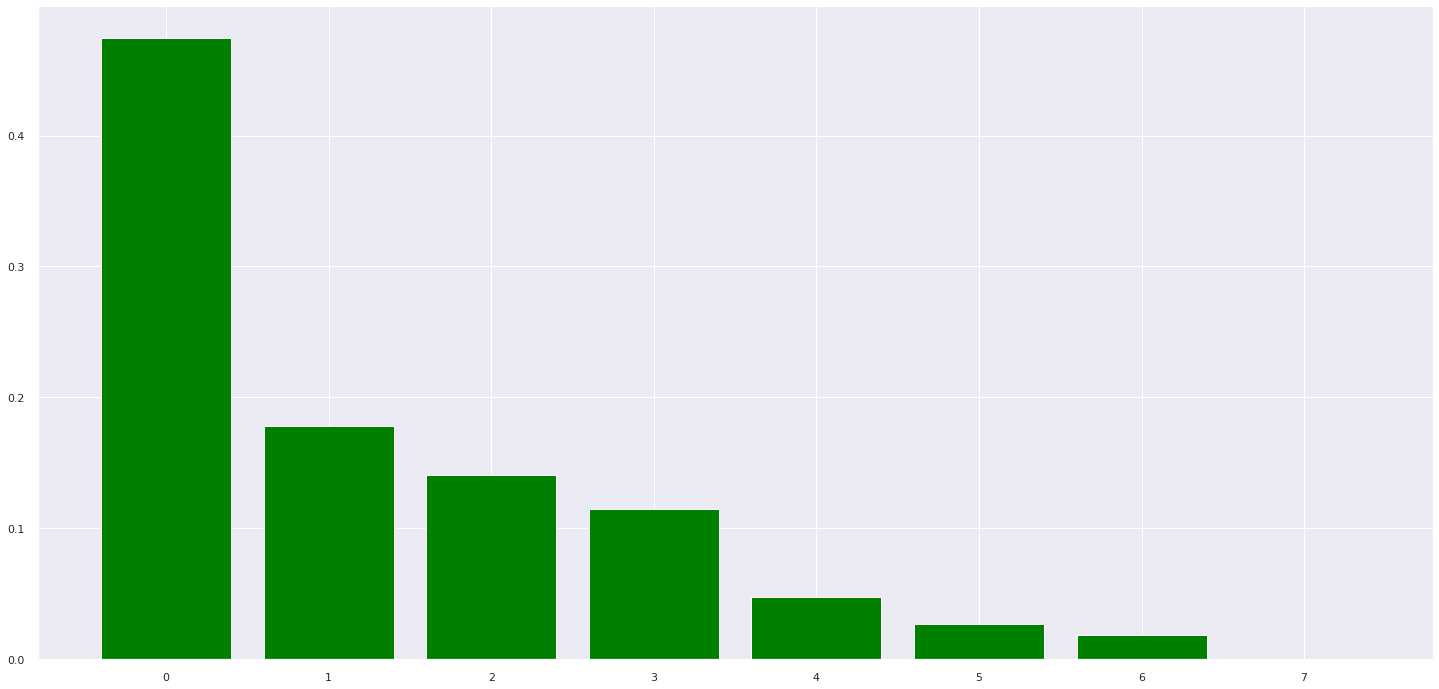

In [ ]:
# method definition
pca=dd.PCA(n_components=8)

# embedding application
x_pca=pca.fit_transform(X)

# Plot explained variables
features=range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='green');

# pca component
df_pca = pd.DataFrame( x_pca )

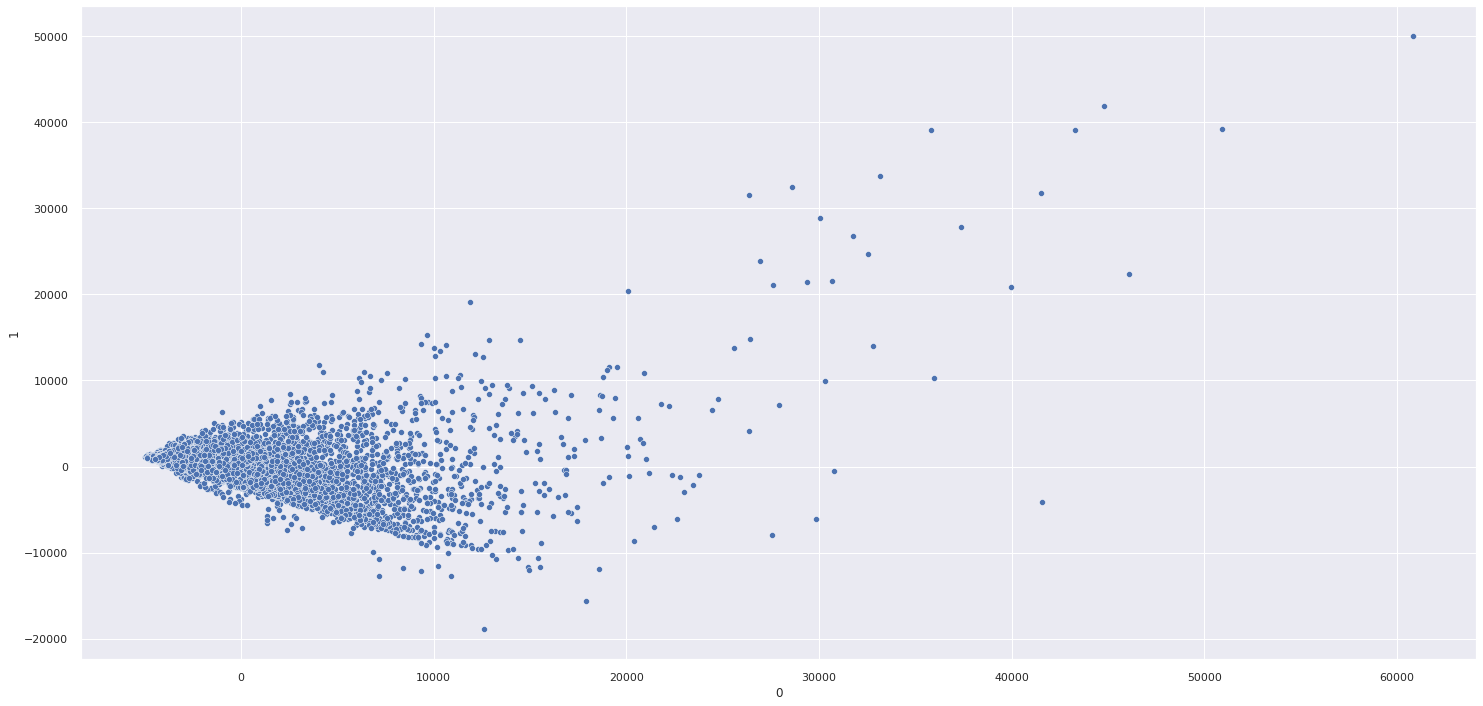

In [ ]:
sns.scatterplot( x=0, y=1, data=df_pca );

### 6.1.2 UMAP

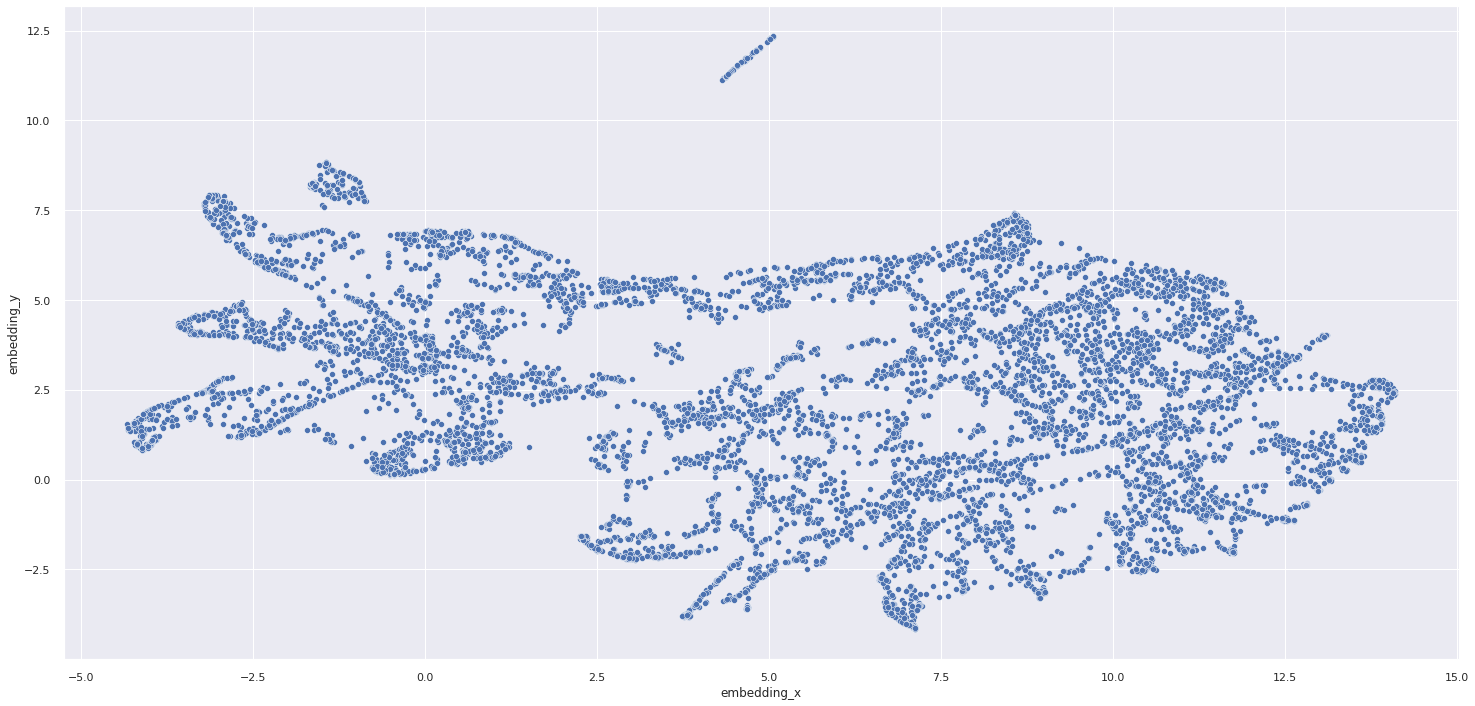

In [ ]:
reducer=umap.UMAP(random_state=42)
x_umap=reducer.fit_transform(X)

# embedding
df_umap=pd.DataFrame()
df_umap['embedding_x']=x_umap[:, 0]
df_umap['embedding_y']=x_umap[:, 1]

# plot UMAP 2D
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap);

### 6.1.3 TSNE

/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


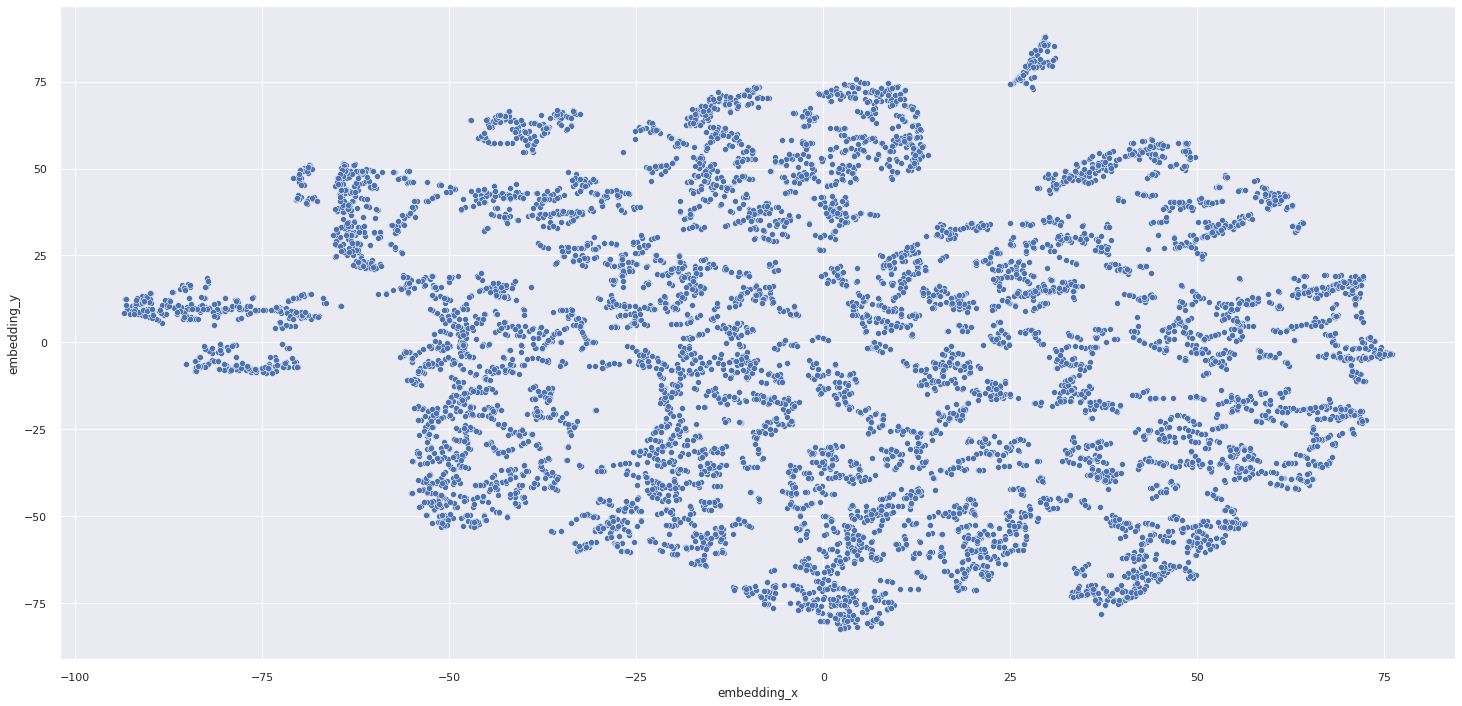

In [ ]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42,  init='random' )
embedding = reducer.fit_transform( df60 )

# embedding
df_tsne=pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_tsne, palette='deep' );

### 6.1.4 Tree-Based Embedding

In [ ]:
df6.columns

Index(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure'],
      dtype='object')

In [ ]:
# training dataset
X = df6.drop( columns=['cust_id', 'balance'], axis=1 )
y = df6['balance']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 
df_leaf = pd.DataFrame( rf_model.apply( X ) )

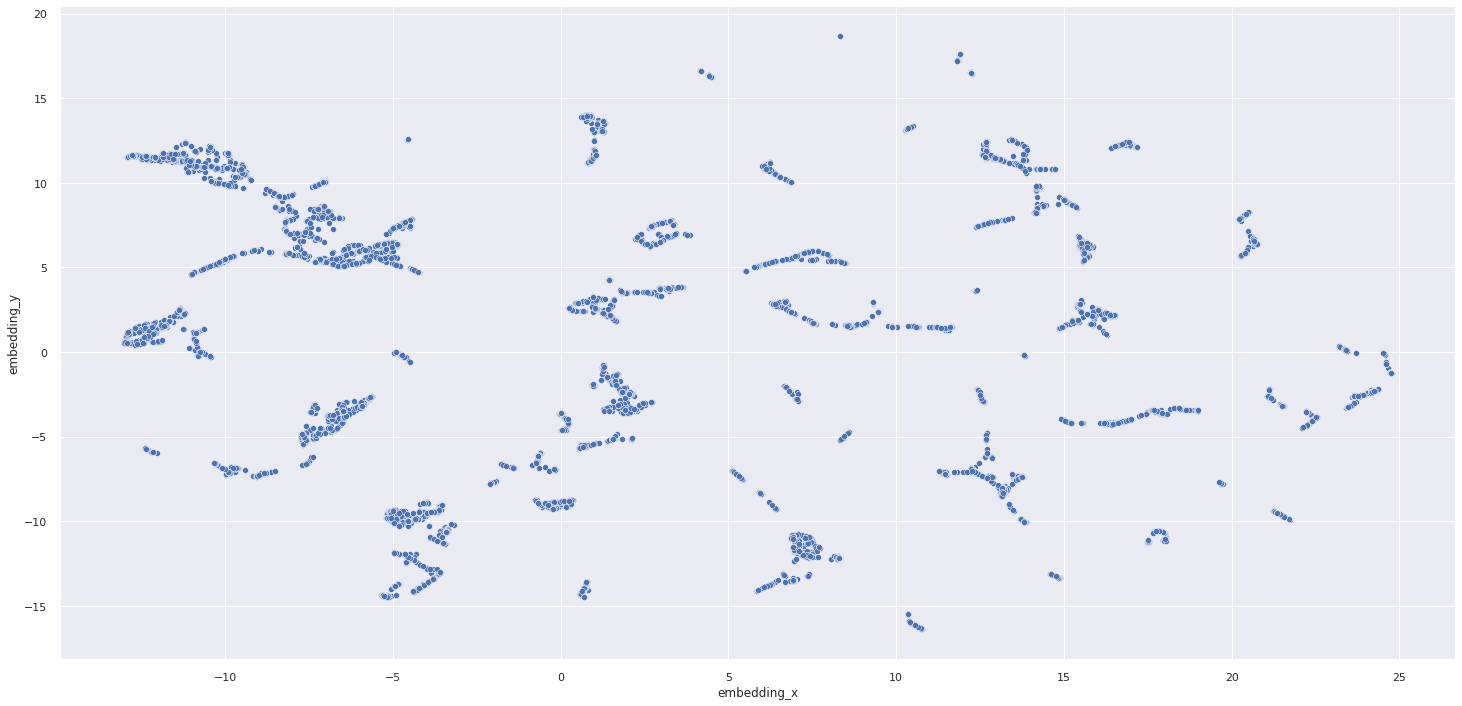

In [ ]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree );

# 7.0 Model Training 

In [ ]:
clusters = np.arange(2,20,1)
X=df_tree.copy()
X.head()

embedding_x  embedding_y
0    -4.493826     7.394582
1    13.874451    11.367612
2    12.176983    -7.031705
3     0.062137    -3.661916
4    16.671658    -4.133374

In [ ]:
# # X = df6.drop(columns=['cust_id'],axis=1)

# silhouette_list = []
# davies_list = []

# for k in clusters:
#     # model definition
#     kmeans_model=c.KMeans(n_clusters=k)

#     # model Training
#     kmeans_model.fit(X)

#     # model predict
#     labels=kmeans_model.predict(X)

#     # model performance
#     sil = m.silhouette_score (X, labels)
#     dav = m.davies_bouldin_score(X, labels)

#     silhouette_list.append(sil)
#     davies_list.append(dav)
#     print(sil)

0.511309783606338
0.4649618076754942
0.3896205546636654
0.37856571386585214
0.40609485280339663
0.36905277029418126
0.3829728277295885


In [ ]:
# X1=df6.copy()
# # = df60.drop(columns=['cust_id'],axis=1)
# clusters = [2, 3, 4, 5, 6, 7, 8]

# silhouette_list = []
# davies_list = []

# for k in clusters:
#     # model definition
#     kmeans_model=c.KMeans(n_clusters=k)

#     # model Training
#     kmeans_model.fit(X1)

#     # model predict
#     labels=kmeans_model.predict(X1)

#     # model performance
#     sil = m.silhouette_score (X1, labels)
#     dav = m.davies_bouldin_score(X1, labels)

#     silhouette_list.append(sil)
#     davies_list.append(dav)
#     print(sil)

0.51327286116905
0.4565436464210238
0.42564852389268243
0.38224864953423116
0.39133713623110256
0.3642714810101305
0.37388262313212234


## 7.1 K-means

In [ ]:
kmeans_list = []
davies_list = []

for k in clusters:
    # model definition
    kmeans_model=c.KMeans(n_clusters=k)

    # model Training
    kmeans_model.fit(X)

    # model predict
    labels=kmeans_model.predict(X)

    # model performance
    sil = mtr.silhouette_score (X, labels, metric='euclidean')
    dav = mtr.davies_bouldin_score(X, labels)

    kmeans_list.append(sil)
    davies_list.append(dav)
    print(sil)

0.42672342
0.43744254
0.4412883
0.43818668
0.45931795
0.4490031
0.4593985
0.48045754
0.48465747
0.4883915
0.4934735
0.50743824
0.5144838
0.53087074
0.53330785
0.5317531
0.5378637
0.54919165


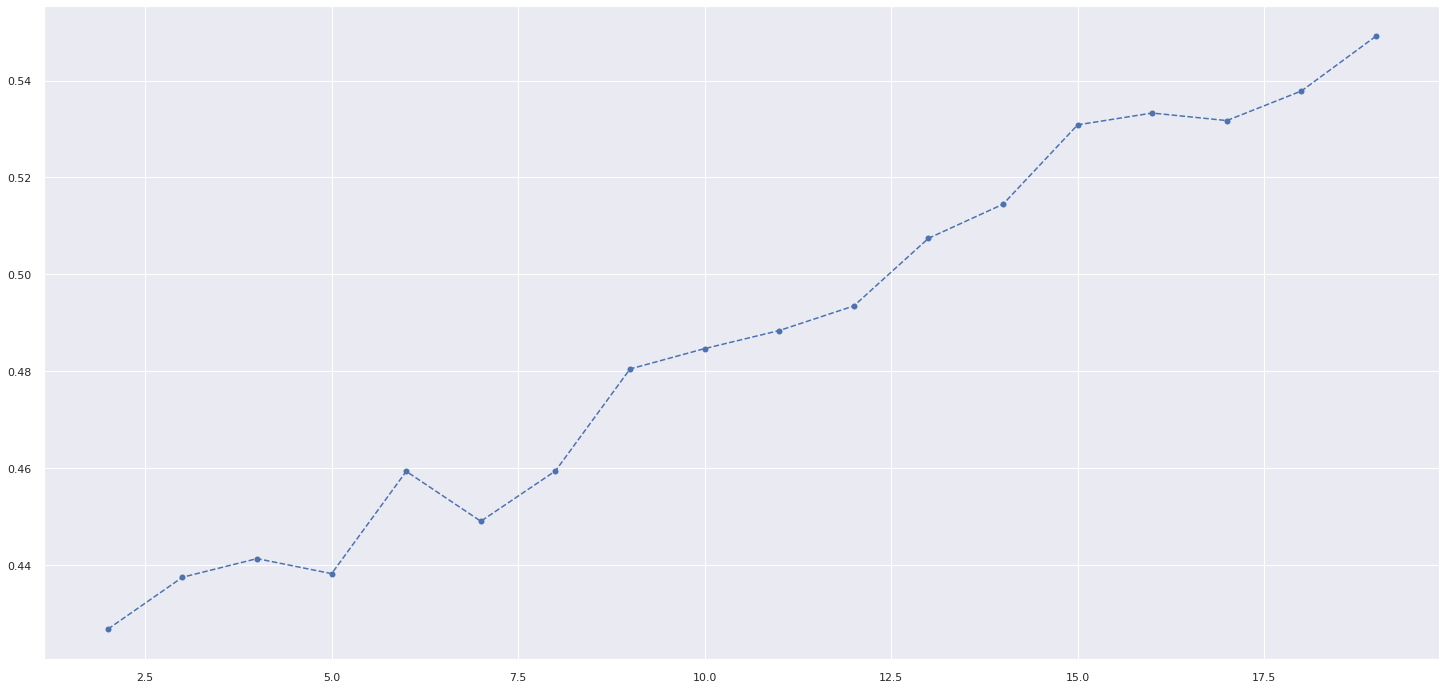

In [ ]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b');

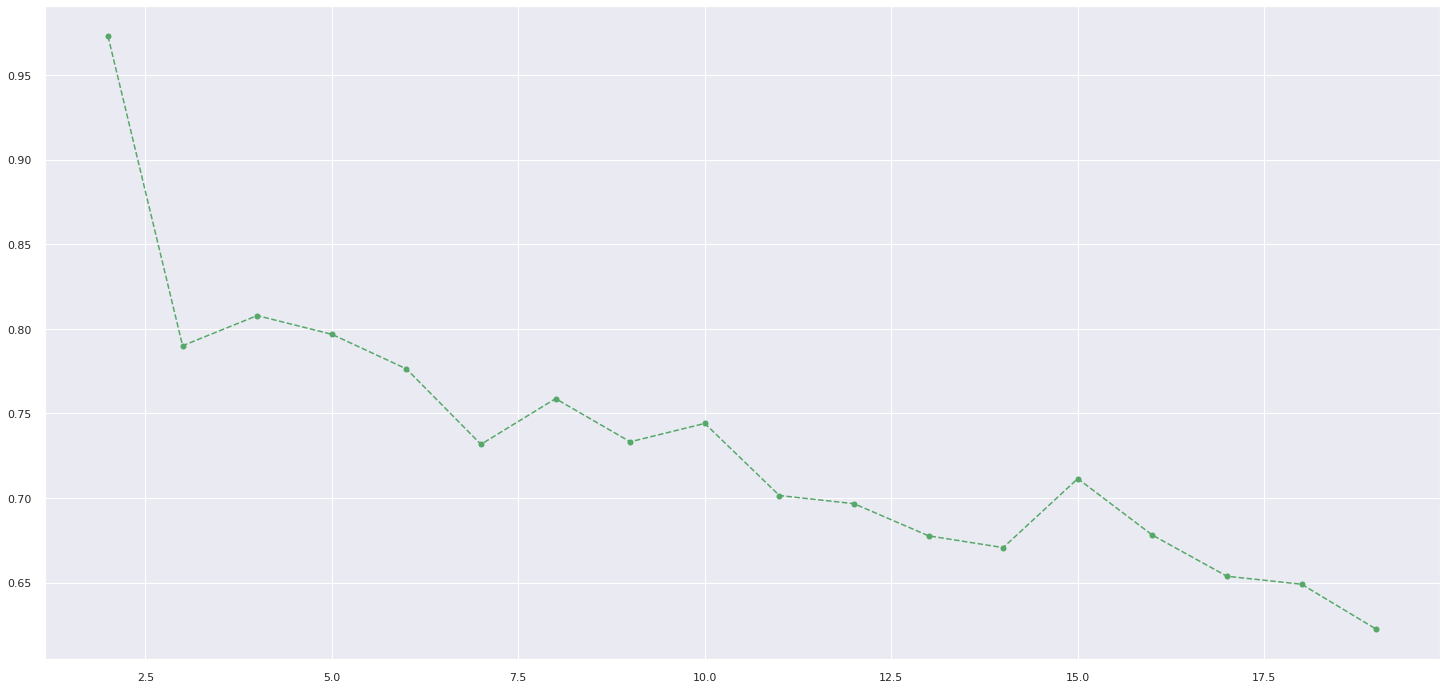

In [ ]:
plt.plot(clusters, davies_list, linestyle='--', marker='o', color='g');


## 7.2 GMM

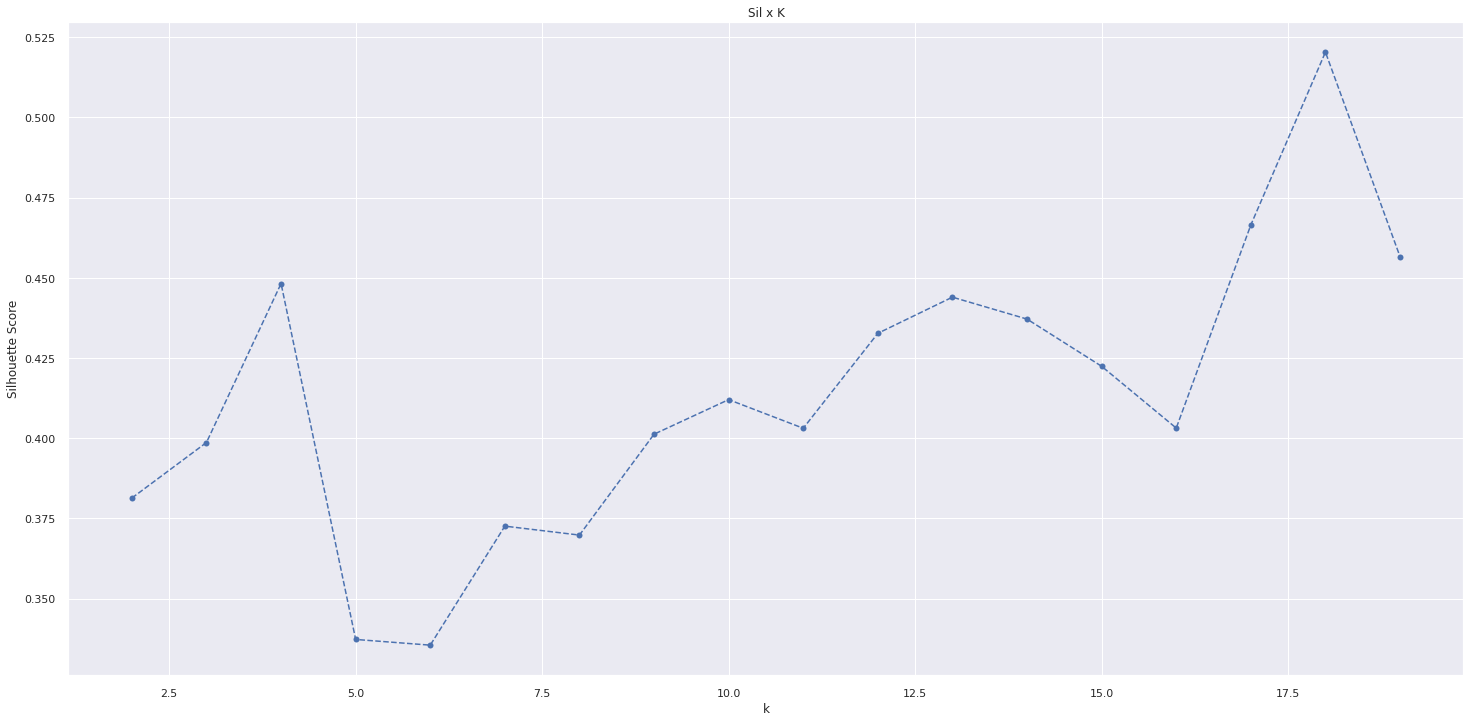

In [ ]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k, n_init=10, random_state=42 )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = mtr.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3. Hierarchical Clustering

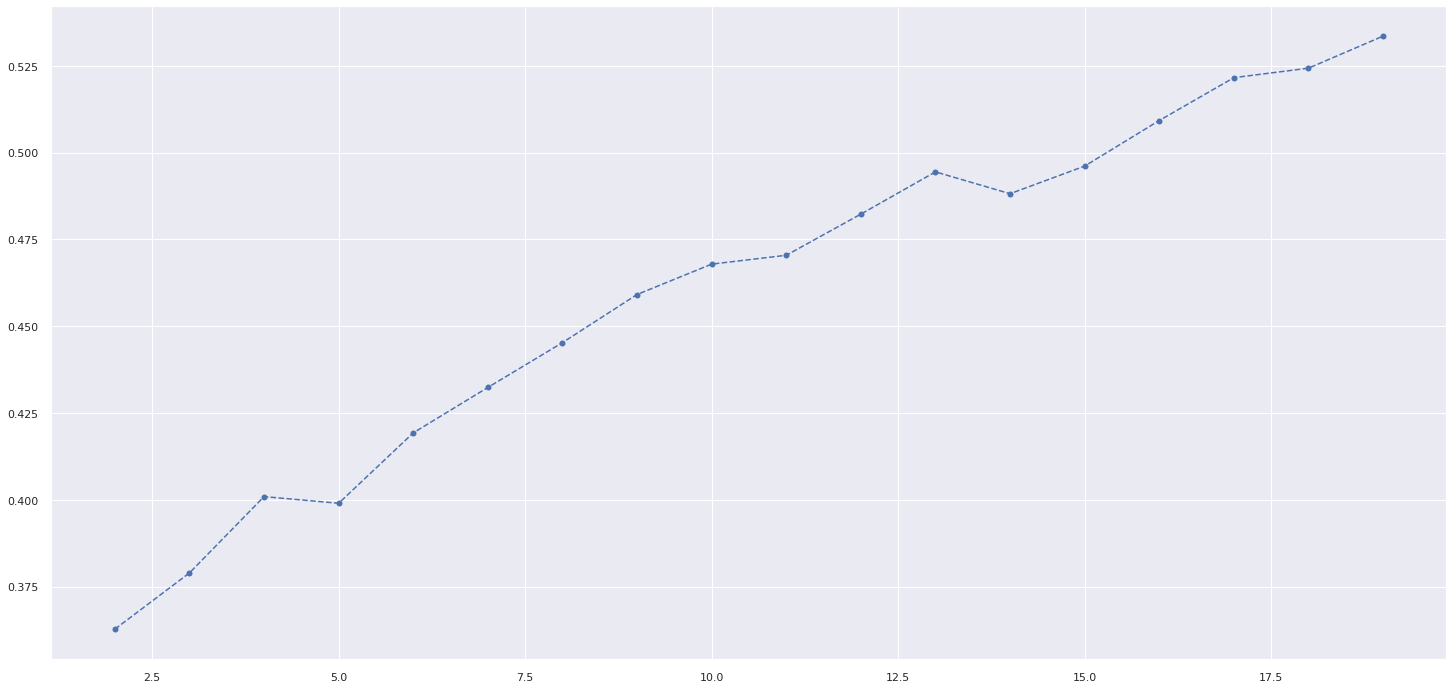

In [ ]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = mtr.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' );

## 7.4 Results - Tree Based

In [ ]:
df_results = pd.DataFrame({'KMeans': kmeans_list, 'GMM': gmm_list, 'HC': hc_list}).T
     
df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )

# 8.0 Hyperparameter fine tuning

In [ ]:
df8=df7.copy()

## 8.1 Within-Cluster Sum of Square (WSS)
    - Measure how compact the clusters are

In [ ]:
k=6

# model definition
kmeans=c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model Training
kmeans.fit(X)

# model predict
labels=kmeans.predict(X)

print( 'SS value: {}'.format( mtr.silhouette_score( X, labels, metric='euclidean' ) ) )


SS value: 0.45661911368370056


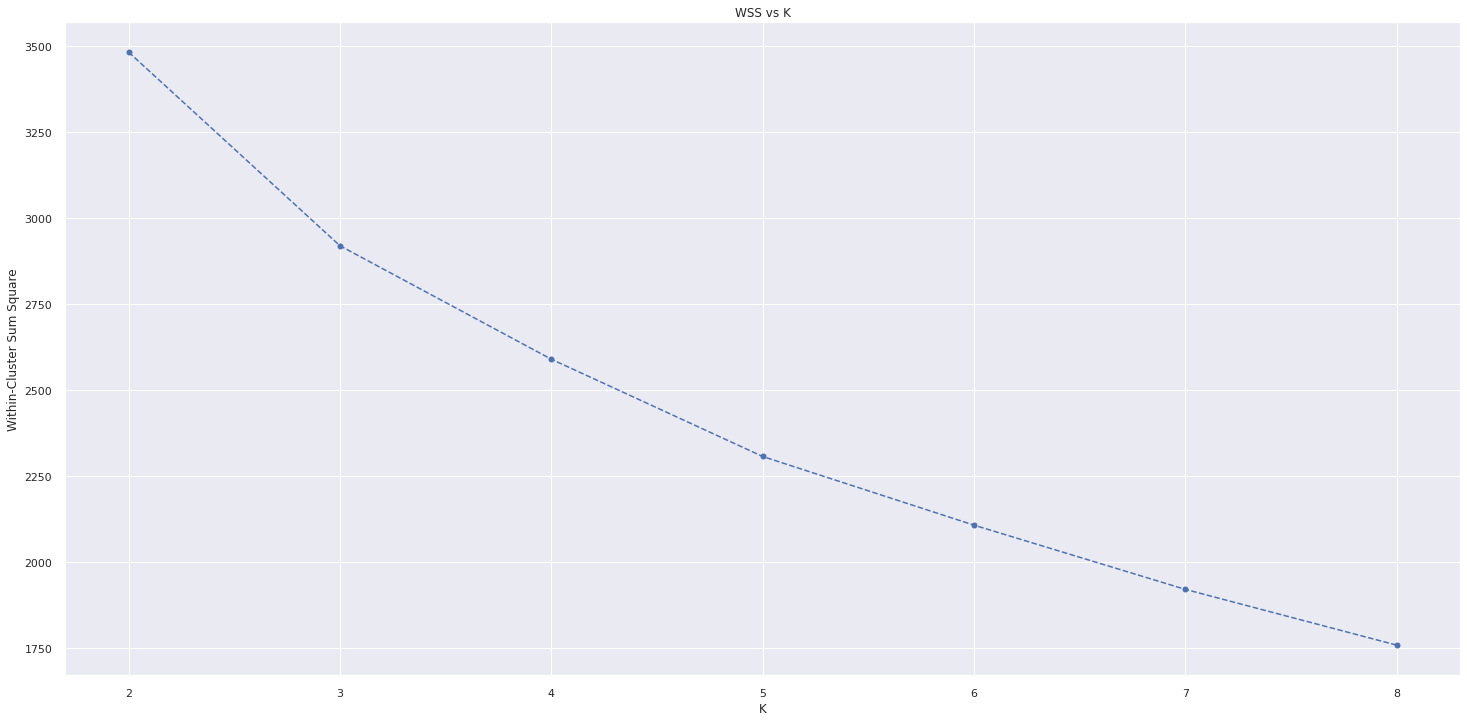

In [ ]:
wss = []
for k in clusters:
    # model definition
    kmeans=c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

    # model Training
    kmeans.fit(X)

    # validation
    wss.append( kmeans.inertia_)

# plot wss elbow method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum Square');
plt.title('WSS vs K');

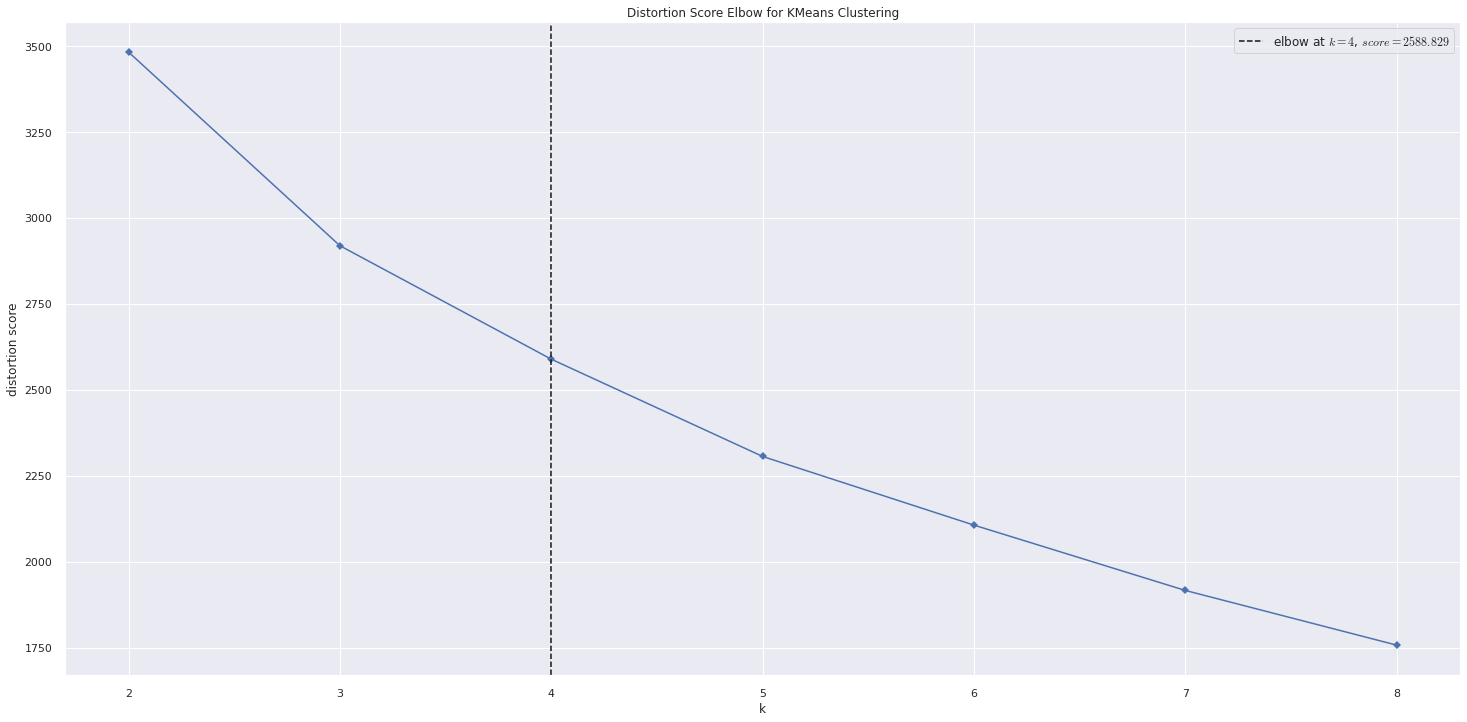

In [ ]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False );
kmeans.fit(X)
kmeans.show();

## 8.2 Sillhouette Score
    - Measure how good is the separation btw clusters

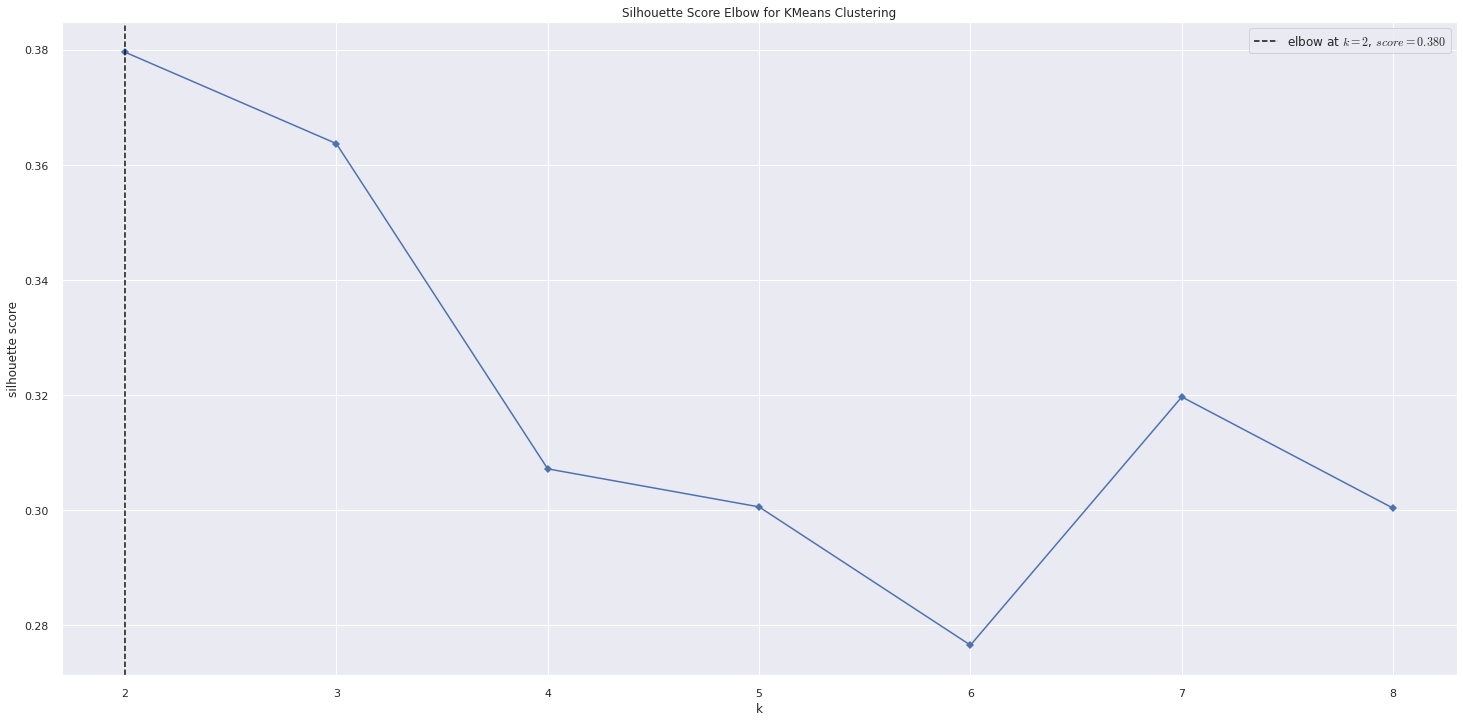

In [ ]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show();

# 9.0 Cluster Analysis

In [ ]:
df9 = X.copy()
df9['cluster'] = labels

## 9.1. Visualization Inspection

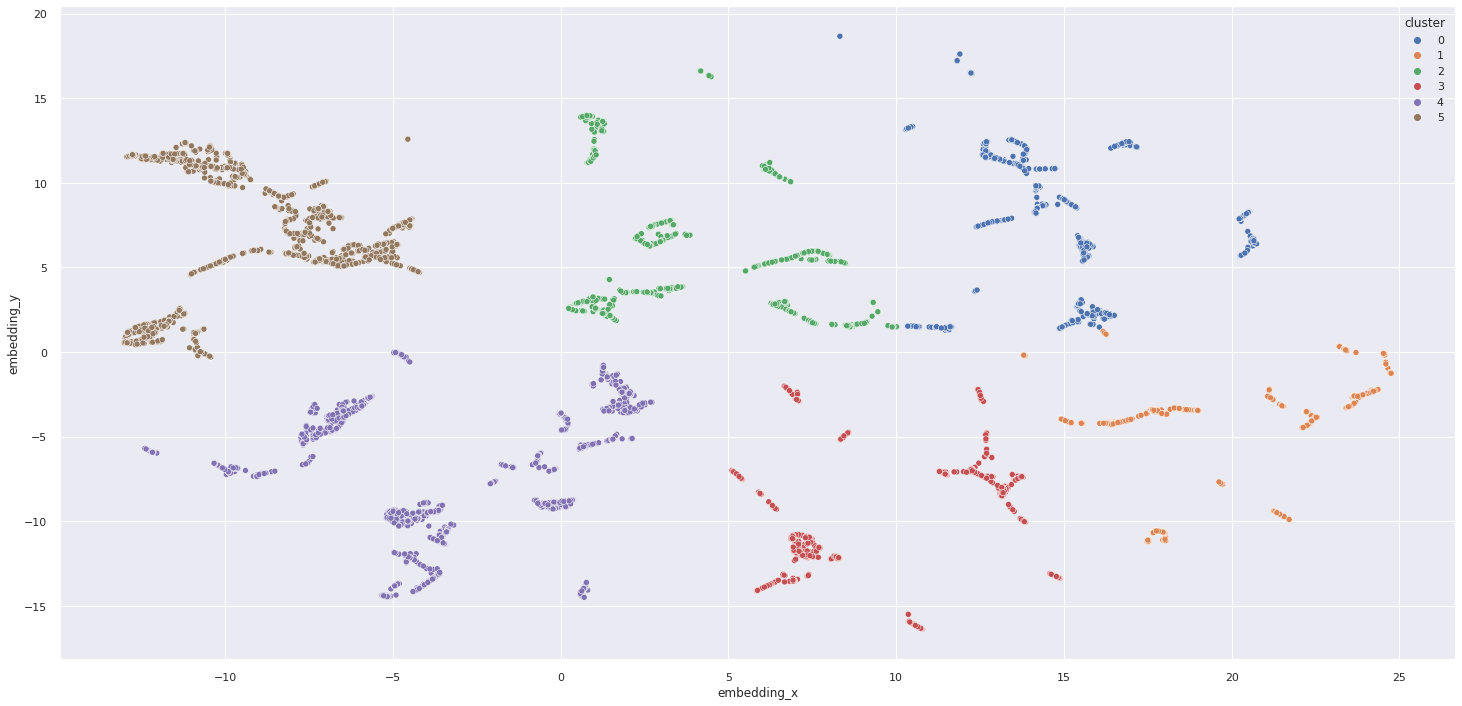

In [ ]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

In [ ]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

cust_id      balance  balance_frequency  purchases  oneoff_purchases  installments_purchases  cash_advance  purchases_frequency  oneoff_purchases_frequency  purchases_installments_frequency  cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit     payments  minimum_payments  prc_full_payment  tenure  cluster
0  C10001    40.900749           0.818182      95.40                 0                   95.40      0.000000             0.166667                    0.000000                          0.083333                    0.00                 0              2          1000   201.802084        139.509787          0.000000      12        5
1  C10002  3202.467416           0.909091       0.00                 0                    0.00   6442.945483             0.000000                    0.000000                          0.000000                    0.25                 4              0          7000  4103.032597       1072.340217          0.222222      12        0
2  C10003  2495.148862           1.000000     773.17               773                    0.00      0.000000             1.000000                    1.000000                          0.000000                    0.00                 0             12          7500   622.066742        627.284787          0.000000      12        3
4  C10005   817.714335           1.000000      16.00                16                    0.00      0.000000             0.083333                    0.083333                          0.000000                    0.00                 0              1          1200   678.334763        244.791237          0.000000      12        4
5  C10006  1809.828751           1.000000    1333.28                 0                 1333.28      0.000000             0.666667                    0.000000                          0.583333                    0.00                 0              8          1800  1400.057770       2407.246035          0.000000      12        1

In [ ]:
# Number of customer
df_cluster = df9[['cust_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['cust_id'] / df_cluster['cust_id'].sum() )

# Avg Gross revenue
df_avg_balance = df9[['balance', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_balance, how='inner', on='cluster' )

df_cluster.head()

cluster  cust_id  perc_customer      balance
0        0     1243      14.393238  3692.811974
1        1      874      10.120426  4893.777634
2        2     1255      14.532191  1046.762271
3        3     1226      14.196387  1968.009511
4        4     2084      24.131542   510.388561

# 10.0 Deploy to production

In [ ]:
df10=df9.copy()


In [ ]:
from sklearn.metrics import (
    silhouette_samples,
    silhouette_score,
    davies_bouldin_score
)

def silhouette(model, X, keyword, keyword_range, plot=False, **kwargs):
    """
    Evaluate Silhouette score for a model with a range of values for keyword argument.
    
    Input:
    ------
    model -- model to be scored
    X -- features
    keyword -- model keyword to use for evaluation
    keyword_range -- range of values for keyword
    plot -- boolean if set to true, then Silhouette score will be plotted
    kwargs -- the rest of the model kwargs (optional)
    """

    for kw_value in keyword_range:
        if plot:
            fig, ax = plt.subplots()
            fig.set_size_inches(14, 7)

            # The silhouette coefficient can range from -1, 1 but in this example all
            # lie within [-0.1, 1]
            ax.set_xlim([-0.1, 1])
            # The (kw_value+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax.set_ylim([0, len(X) + (kw_value + 1) * 10])

        # Initialize the clusterer with kw_value value and a random generator
        # seed of 10 for reproducibility.
        clusterer = model(**{keyword: kw_value}, **kwargs)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            f"For {keyword} =",
            kw_value,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        if plot:
            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(len(set(cluster_labels))):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[
                    cluster_labels == i
                ]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                ax.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
                ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax.set_title(f"The silhouette plot for {kw_value} {keyword}.")
            ax.set_xlabel("The silhouette coefficient values")
            ax.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax.set_yticks([])  # Clear the yaxis labels / ticks
            ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    if plot:
        plt.show()

For n_clusters = 5 The average silhouette_score is : 0.37487175471379103
For n_clusters = 6 The average silhouette_score is : 0.37172163051233087
For n_clusters = 7 The average silhouette_score is : 0.3696417127315634


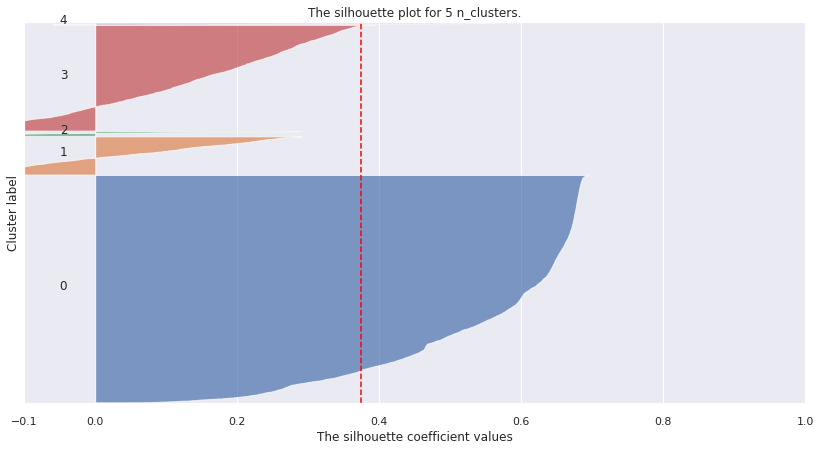

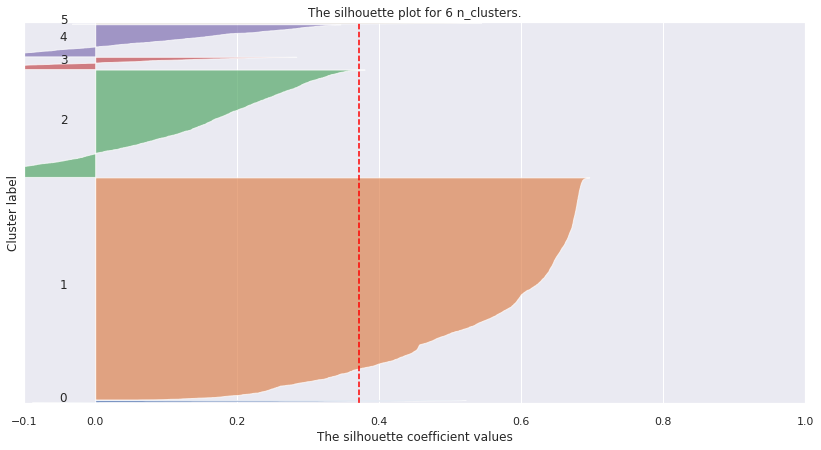

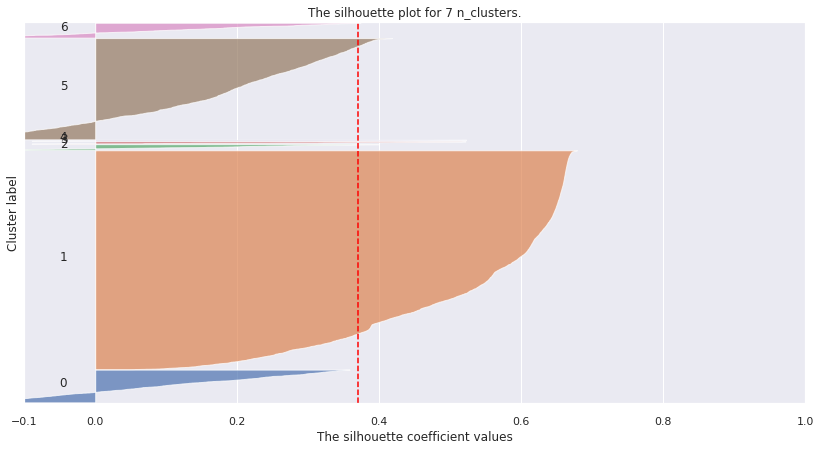

In [ ]:
silhouette(c.KMeans, x_pca, "n_clusters", [5, 6, 7], True, random_state=1)

- Artificial dataset
- Detection of outliers with isolation forest
    - parameters


- Train ml
    - Algorithm+outliers

In [ ]:
from matplotlib import pyplot as plt

from sklearn import metrics as m
from sklearn import datasets as dt
from sklearn import cluster as c


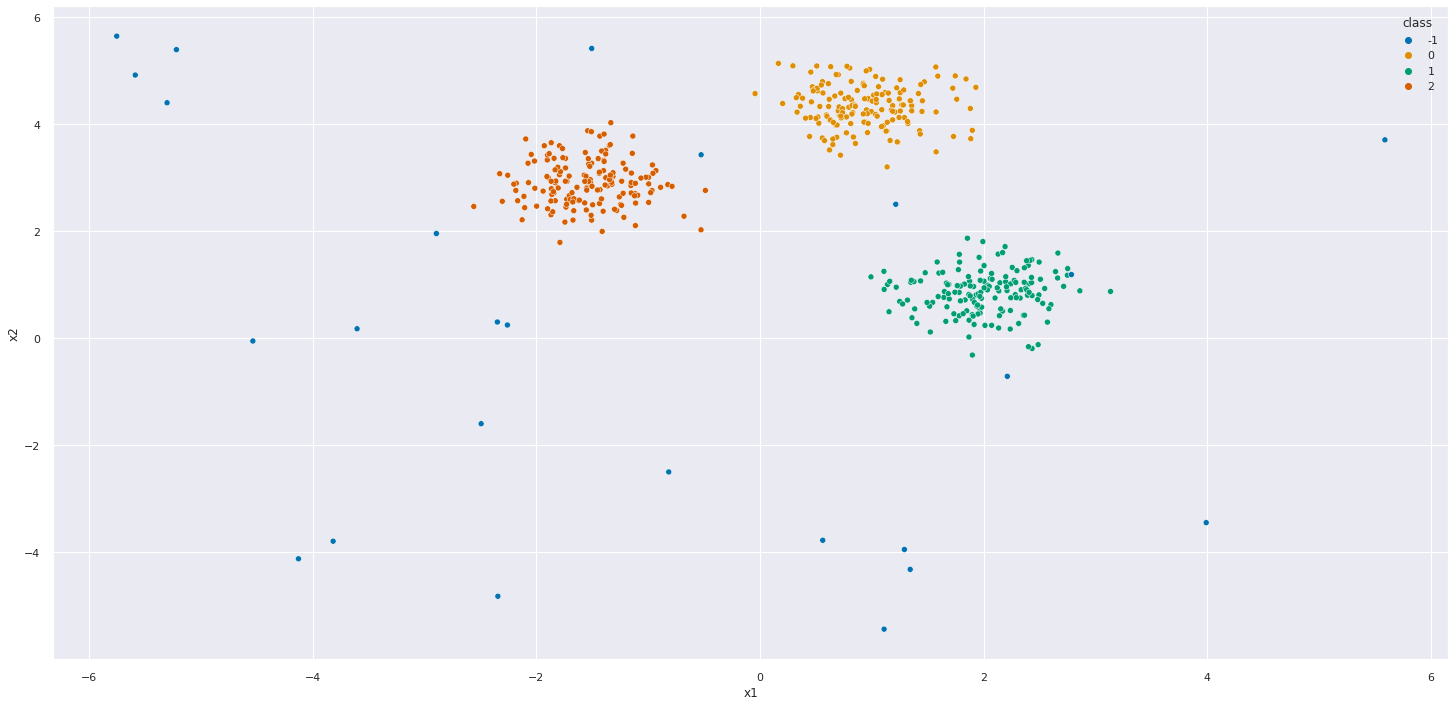

In [ ]:
n_samples = 500
outliers_fractions = 0.05
n_features=2
n_clusters = 3
n_outliers= int(outliers_fractions * n_samples)
n_inliers= n_samples - n_outliers
blobs_params=dict(random_state=0, n_samples=n_inliers, n_features=n_features )
X,y=dt.make_blobs(centers=n_clusters, cluster_std=0.4, **blobs_params )
df=pd.DataFrame(X, columns=['x' + str(i) for i in list(range(1, n_features+1))])
df['class']=y

rng=np.random.RandomState(42)
df_noise=pd.DataFrame(rng.uniform(low=-6,
                     high=6,
                     size=(n_outliers, n_features)), columns=['x' + str(i) for i in list(range(1, n_features+1))])
df_noise['class']=-1

df_raw=pd.concat([df, df_noise], axis=0)

sns.scatterplot(x='x1', y='x2', hue='class', palette='colorblind', data= df_raw);

In [ ]:
df.head()

x1        x2  class
0 -1.831750  2.562770      2
1  0.969462  4.455448      0
2  1.252886  4.581687      0
3  0.593892  4.165395      0
4  1.185826  4.339156      0

/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


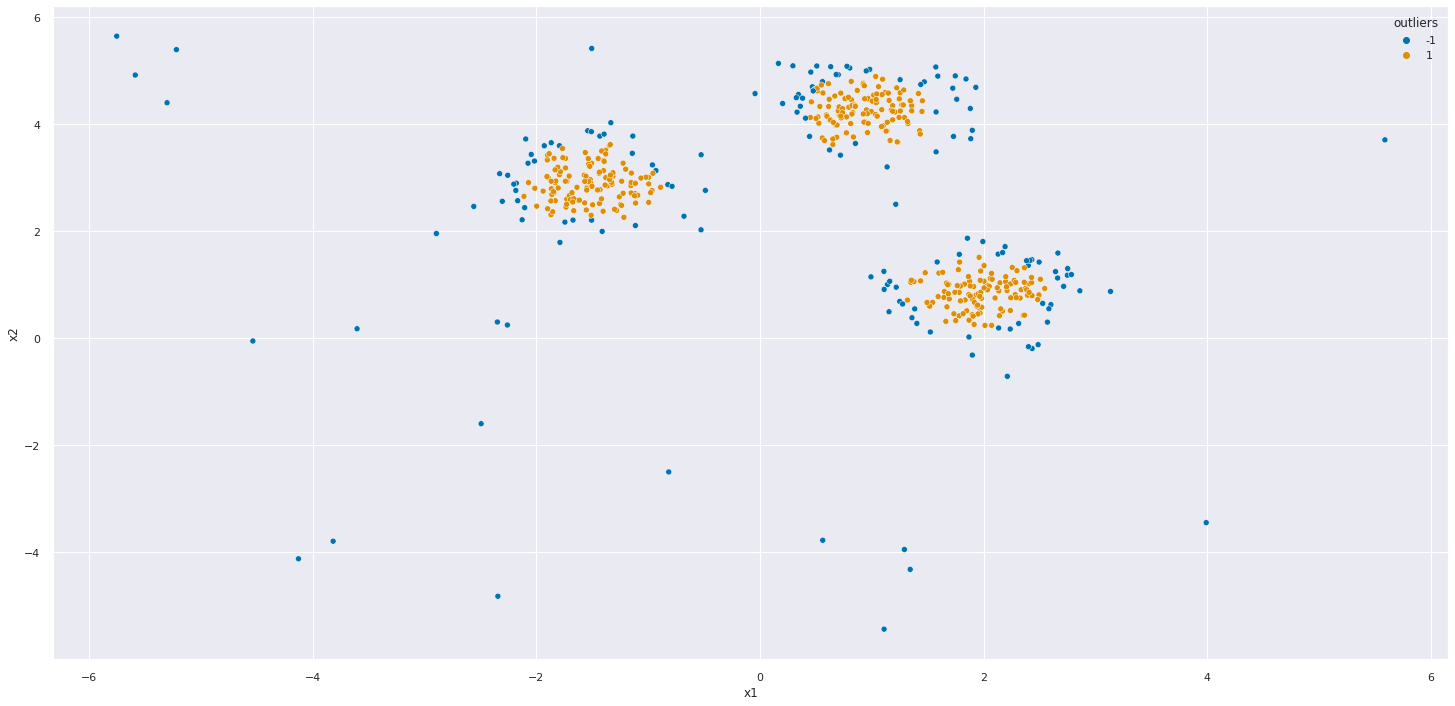

In [ ]:
# training isolation forest
X=df_raw.drop('class', axis=1)

# model definition
iso_model=en.IsolationForest(n_estimators=100, max_samples=300, bootstrap=True, contamination=0.30, random_state=rng, n_jobs=-1)


# predict
preds = iso_model.fit_predict(X)

# pred_scores=-1*iso_model.score_samples(X)

# performance
X['outliers']=preds

sns.scatterplot(x='x1', y='x2', hue='outliers', palette='colorblind', data= X);

In [ ]:
X.head()

x1        x2  outliers
0 -1.831750  2.562770         1
1  0.969462  4.455448         1
2  1.252886  4.581687         1
3  0.593892  4.165395         1
4  1.185826  4.339156         1

/tmp/ipykernel_11359/4077666657.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='IsolationForestScore');


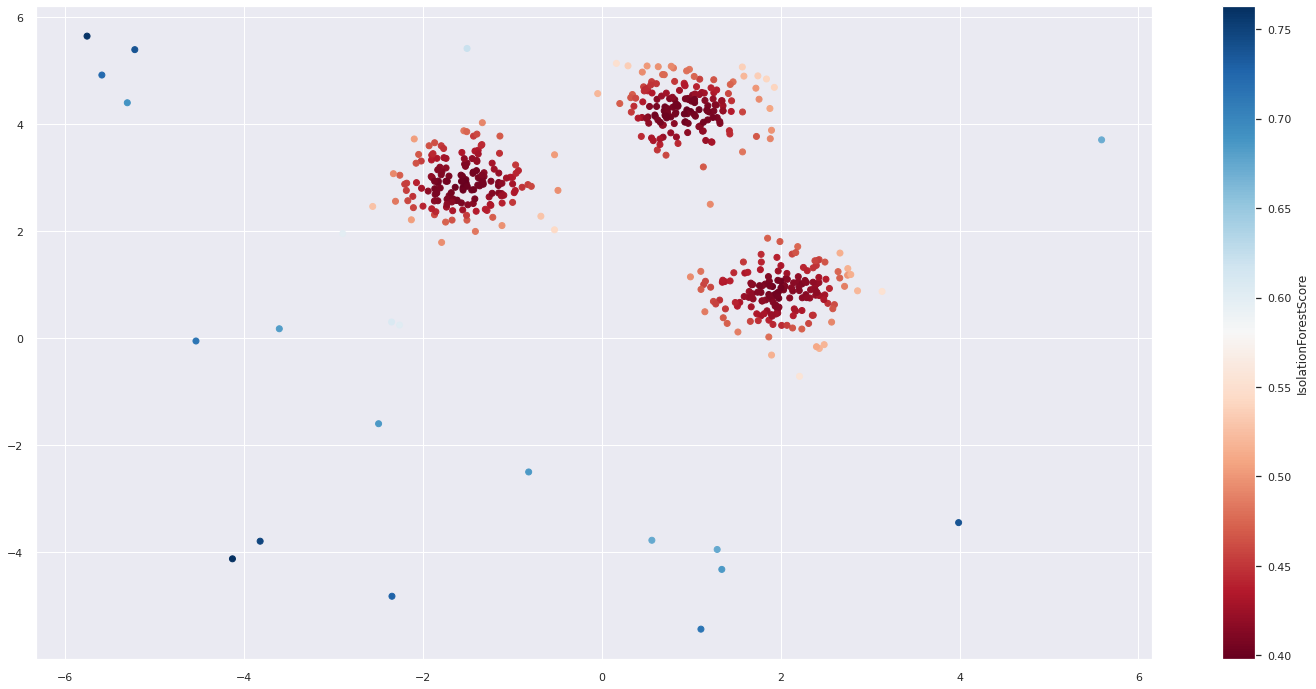

In [ ]:
# training isolation forest
X=df_raw.drop('class', axis=1)

# model definition
iso_model=en.IsolationForest(n_estimators=100,  n_jobs=-1)

iso_model.fit(X)
pred_scores=-1*iso_model.score_samples(X)

# performance
df_raw['outliers']=pred_scores
plt.scatter(df_raw['x1'], df_raw['x2'], c=df_raw['outliers'], cmap='RdBu' );
plt.colorbar(label='IsolationForestScore');

# Removing Outliers

In [ ]:
df_raw['outlier_flag']=df_raw['outliers'].apply(lambda x: 1 if x > 0.55 else 0)

df_raw=df_raw.query('outlier_flag == 0')
df_raw.head()

x1        x2  class  outliers  outlier_flag
0 -1.831750  2.562770      2  0.411727             0
1  0.969462  4.455448      0  0.404004             0
2  1.252886  4.581687      0  0.433564             0
3  0.593892  4.165395      0  0.404299             0
4  1.185826  4.339156      0  0.406874             0

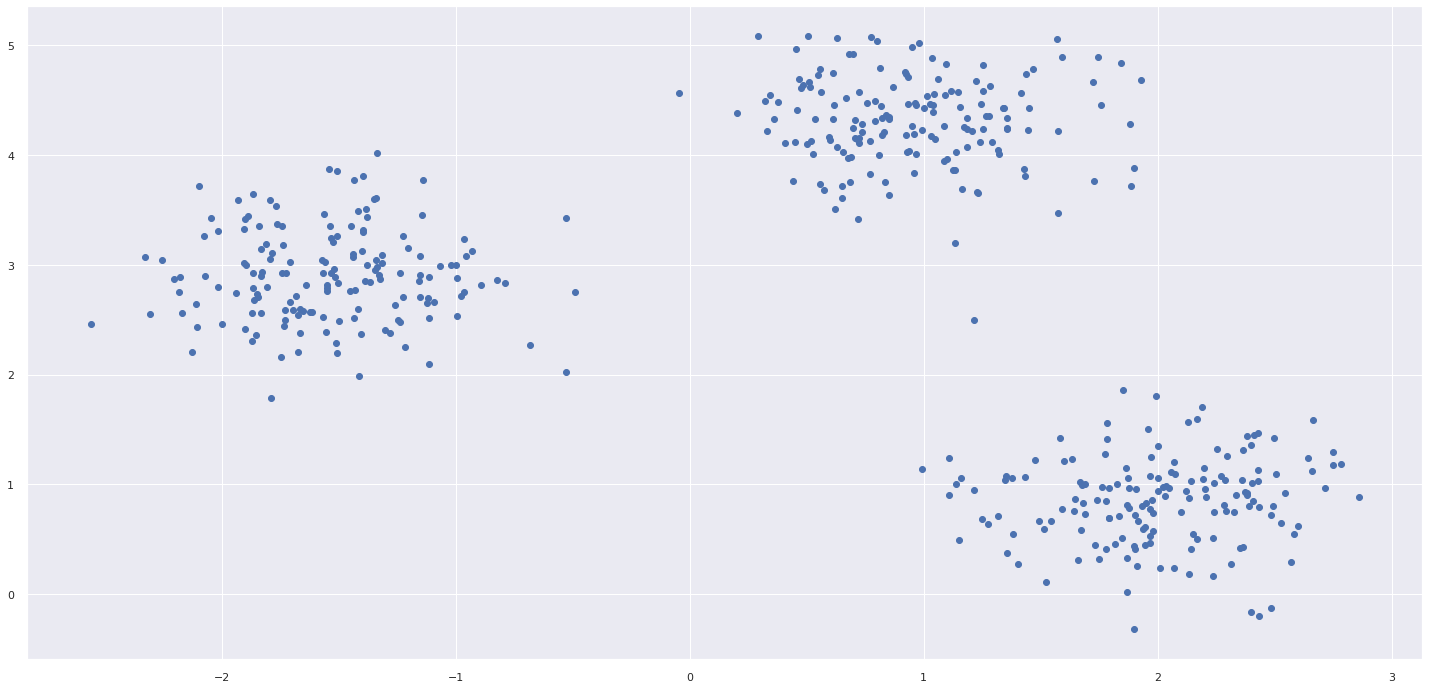

In [ ]:
plt.scatter(df_raw.x1, df_raw.x2,cmap='RdBu' )

# Tuning model

In [ ]:
k=8

# dataset
X = df_raw[['x1','x2']]

# model definition and fit
kmeans_model=c.KMeans(n_clusters=k).fit(X)

#pred
labels = kmeans_model.predict(X)
df_raw['labels']= labels
df_raw.head()

x1        x2  class  outliers  outlier_flag  labels
0 -1.831750  2.562770      2  0.411727             0       4
1  0.969462  4.455448      0  0.404004             0       7
2  1.252886  4.581687      0  0.433564             0       0
3  0.593892  4.165395      0  0.404299             0       7
4  1.185826  4.339156      0  0.406874             0       0

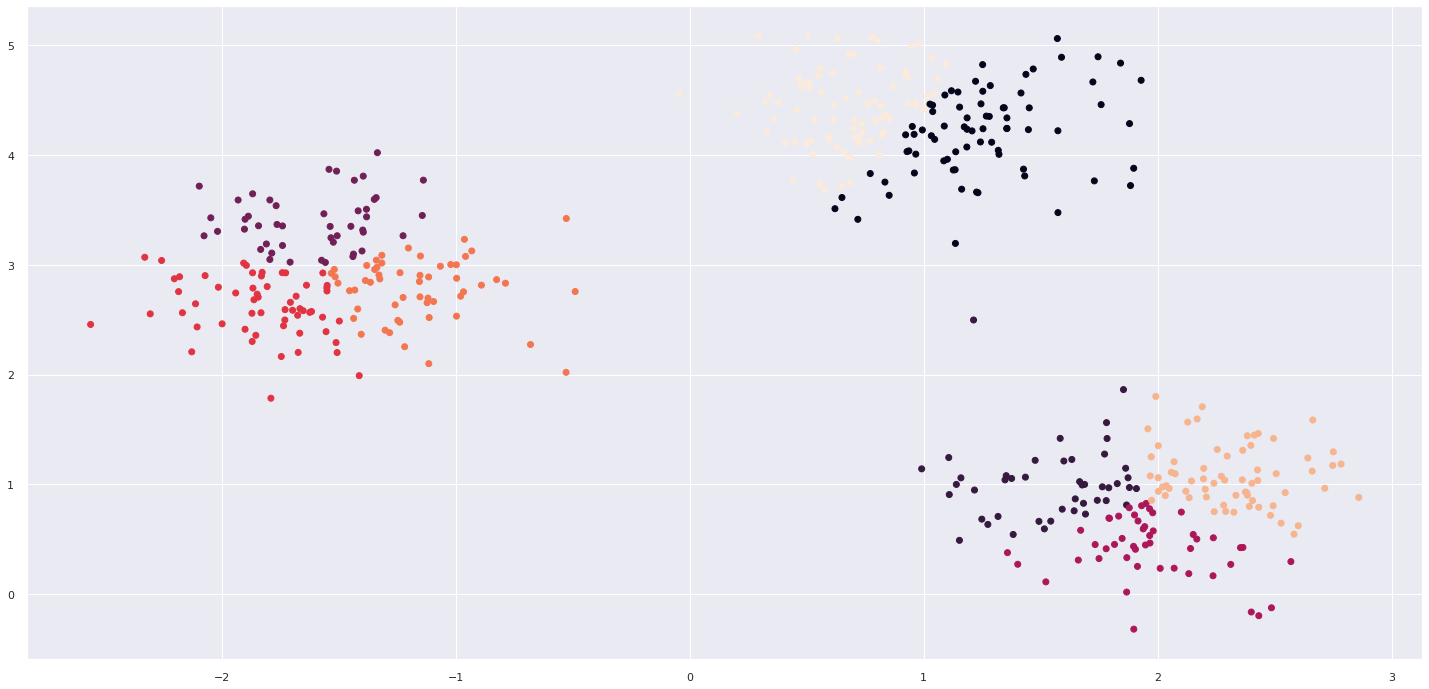

In [ ]:
plt.scatter(df_raw['x1'], df_raw['x2'], c=df_raw['labels'], cmap='rocket' );

In [ ]:
silhouette_list = []
davies_list = []

clusters=list(range(2,9))
for k in clusters:
    # model definition
    kmeans_model=c.KMeans(n_clusters=k)

    # model Training
    kmeans_model.fit(X)

    # model predict
    labels=kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score (X, labels)
    dav = m.davies_bouldin_score(X, labels)

    silhouette_list.append(sil)
    davies_list.append(dav)
    print(sil)

0.623000876946665
0.7696215160738261
0.6160697171397047
0.46745383228278764
0.3194494405865592
0.3345769682387946
0.34675789197048024


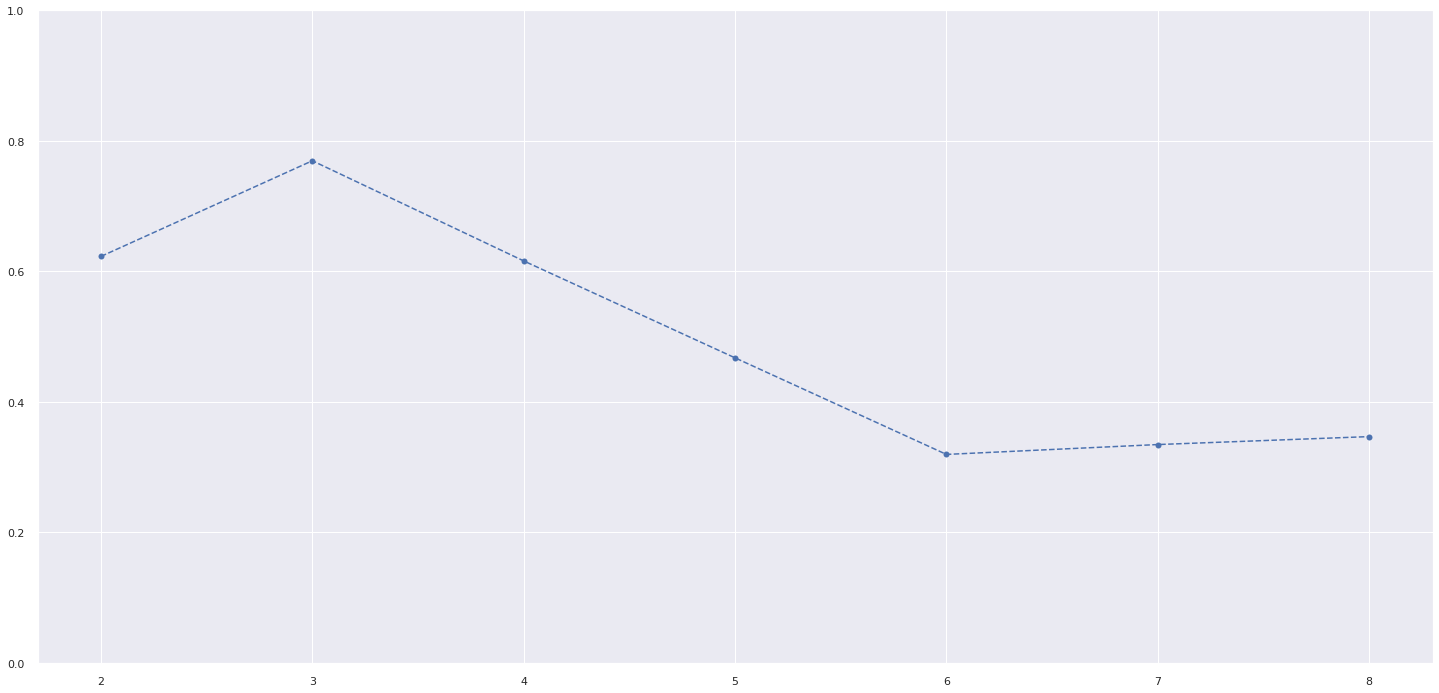

In [ ]:
plt.plot(clusters, silhouette_list, linestyle='--', marker='o', color='b');
plt.ylim(0,1);

# ML training

In [ ]:
k=3

# dataset
X = df_raw[['x1','x2']]

# model definition and fit
kmeans_model=c.KMeans(n_clusters=k).fit(X)

#pred
labels = kmeans_model.predict(X)
df_raw['labels']= labels
df_raw.head()

x1        x2  class  outliers  outlier_flag  labels
0 -1.831750  2.562770      2  0.411727             0       2
1  0.969462  4.455448      0  0.404004             0       0
2  1.252886  4.581687      0  0.433564             0       0
3  0.593892  4.165395      0  0.404299             0       0
4  1.185826  4.339156      0  0.406874             0       0

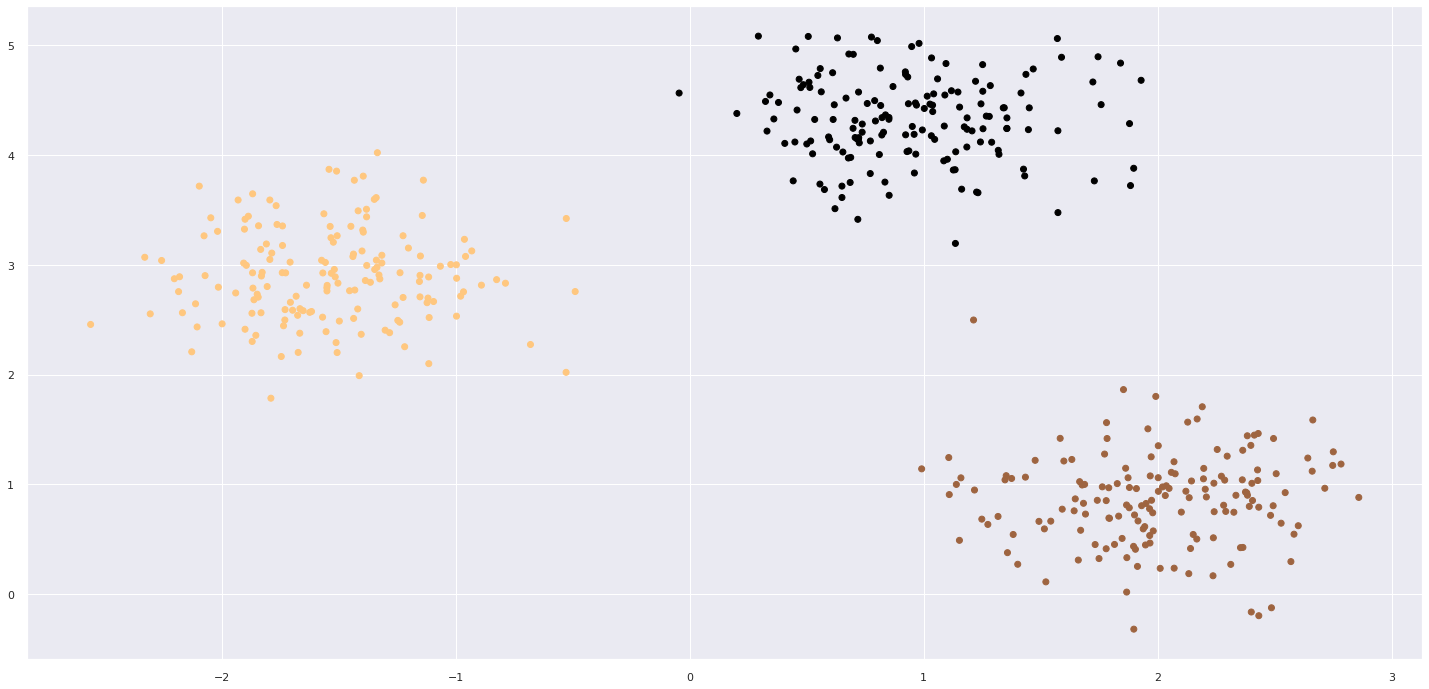

In [ ]:
plt.scatter(df_raw['x1'], df_raw['x2'], c=df_raw['labels'], cmap='copper' );

In [ ]:
# real world 

n_samples = 500
outliers_fractions = 0.05
n_features=5
n_clusters = 3
n_outliers= int(outliers_fractions * n_samples)
n_inliers= n_samples - n_outliers
blobs_params=dict(random_state=0, n_samples=n_inliers, n_features=n_features )
X,y=dt.make_blobs(centers=n_clusters, cluster_std=0.4, **blobs_params )
df=pd.DataFrame(X, columns=['x' + str(i) for i in list(range(1, n_features+1))])
df['class']=y

rng=np.random.RandomState(42)
df_noise=pd.DataFrame(rng.uniform(low=-6,
                     high=6,
                     size=(n_outliers, n_features)), columns=['x' + str(i) for i in list(range(1, n_features+1))])
df_noise['class']=-1

df_raw=pd.concat([df, df_noise], axis=0)
df_raw.head()

x1        x2        x3        x4        x5  class
0  5.854018  0.443610  1.677489  8.325663 -8.324646      2
1  2.950208 -1.303248  8.071728  9.189679 -2.691505      1
2  5.430296  0.494308  1.719903  8.584423 -8.248566      2
3  2.693963 -1.354786  7.707771  9.154051 -2.282094      1
4  6.085978  0.536174  1.507162  8.188924 -8.767595      2

In [ ]:
# training isolation forest
X=df_raw.drop('class', axis=1)

# model definition
iso_model=en.IsolationForest(n_estimators=100,  n_jobs=-1)

iso_model.fit(X)
pred_scores=-1*iso_model.score_samples(X)

# performance
df_raw['outliers']=pred_scores
df_raw.head()

x1        x2        x3        x4        x5  class  outliers
0  5.854018  0.443610  1.677489  8.325663 -8.324646      2  0.403024
1  2.950208 -1.303248  8.071728  9.189679 -2.691505      1  0.410620
2  5.430296  0.494308  1.719903  8.584423 -8.248566      2  0.413152
3  2.693963 -1.354786  7.707771  9.154051 -2.282094      1  0.400250
4  6.085978  0.536174  1.507162  8.188924 -8.767595      2  0.406466

In [ ]:
# sacada de um milhao de dolar

In [ ]:
# with outliers

threshold = 0.55

df_raw['outlier_flag']=df_raw['outliers'].apply(lambda x: 1 if x > threshold else 0)
df_raw.shape

(500, 8)

In [ ]:
silhouette_list = []
davies_list = []

clusters=list(range(2,9))
for k in clusters:
    # model definition
    kmeans_model=c.KMeans(n_clusters=k)

    # model Training
    kmeans_model.fit(X)

    # model predict
    labels=kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score (X, labels)
    dav = m.davies_bouldin_score(X, labels)

    silhouette_list.append(sil)
    davies_list.append(dav)
    print(sil)

0.6261816736065239
0.8256374218832532
0.8330714593067352
0.8348795200399293
0.8363889231470465
0.8335764274154247
0.8369393851405641


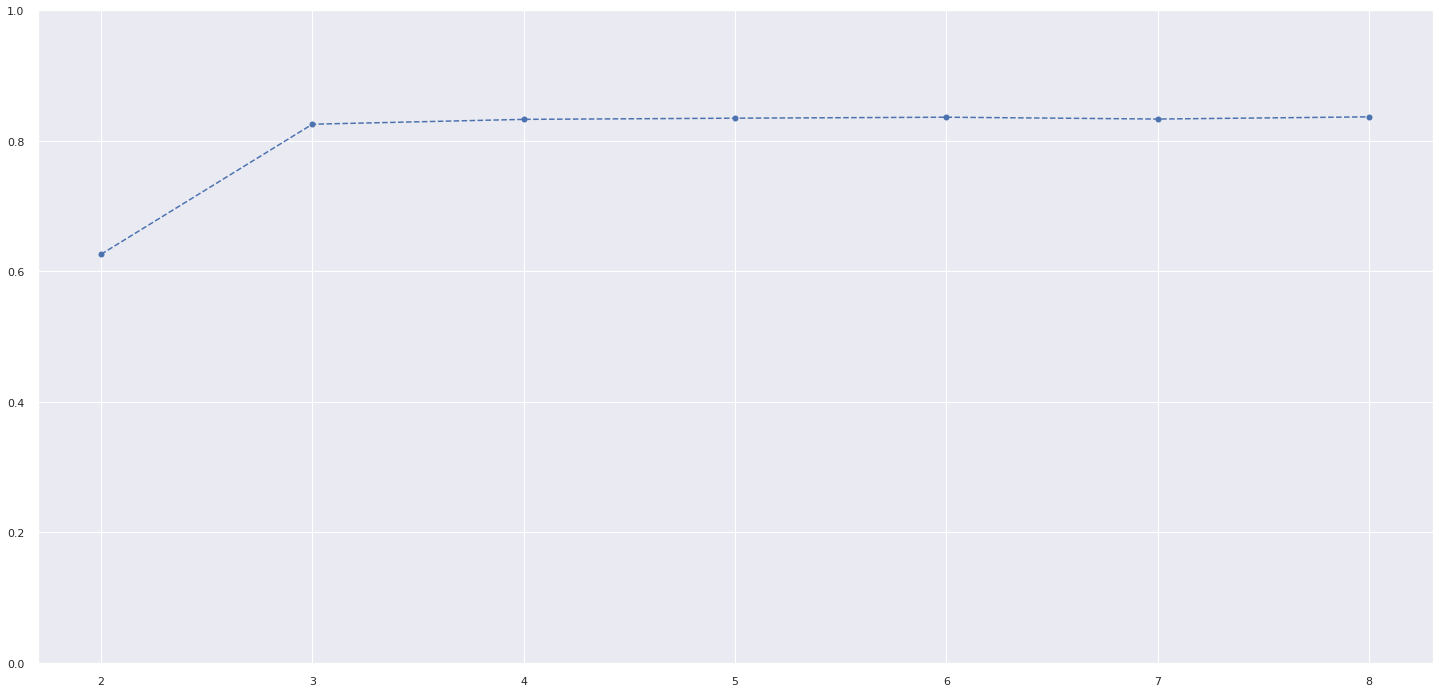

In [ ]:
plt.plot(clusters, silhouette_list, linestyle='--', marker='o', color='b');
plt.ylim(0,1);

In [ ]:
threshold = 0.55

df_raw['outlier_flag']=df_raw['outliers'].apply(lambda x: 1 if x > threshold else 0)

df_raw=df_raw.query('outlier_flag == 0')
df_raw.shape

(475, 8)

In [ ]:
silhouette_list = []
davies_list = []

clusters=list(range(2,9))
for k in clusters:
    # model definition
    kmeans_model=c.KMeans(n_clusters=k)

    # model Training
    kmeans_model.fit(X)

    # model predict
    labels=kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score (X, labels)
    dav = m.davies_bouldin_score(X, labels)

    silhouette_list.append(sil)
    davies_list.append(dav)
    print(sil)

0.6261816736065239
0.8256374218832532
0.8330714593067352
0.8348795200399293
0.8363889231470465
0.8345651400537725
0.8339722136322723


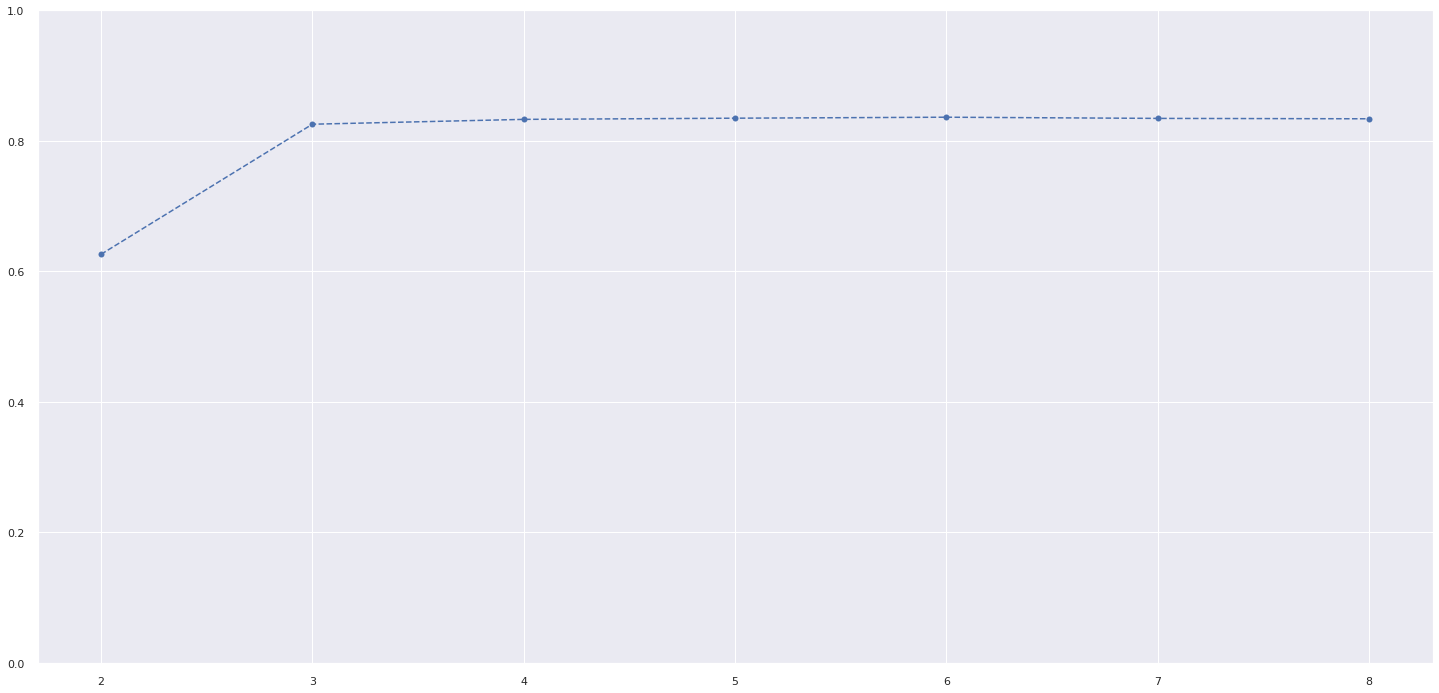

In [ ]:
plt.plot(clusters, silhouette_list, linestyle='--', marker='o', color='b');
plt.ylim(0,1);

- Artificial dataset
    - Changing the space(embedding)
    - Linear changing (PCA)
    - Non linear changing (kernel PCA)
- ML cluster training
    - chech performance

In [ ]:
# exp 1 
from sklearn import datasets as dt
from sklearn import model_selection as ms
from sklearn import decomposition as dc

X,y=dt.make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
x_train,x_test,y_train,y_test= ms.train_test_split( X, y, stratify=y, random_state=0)

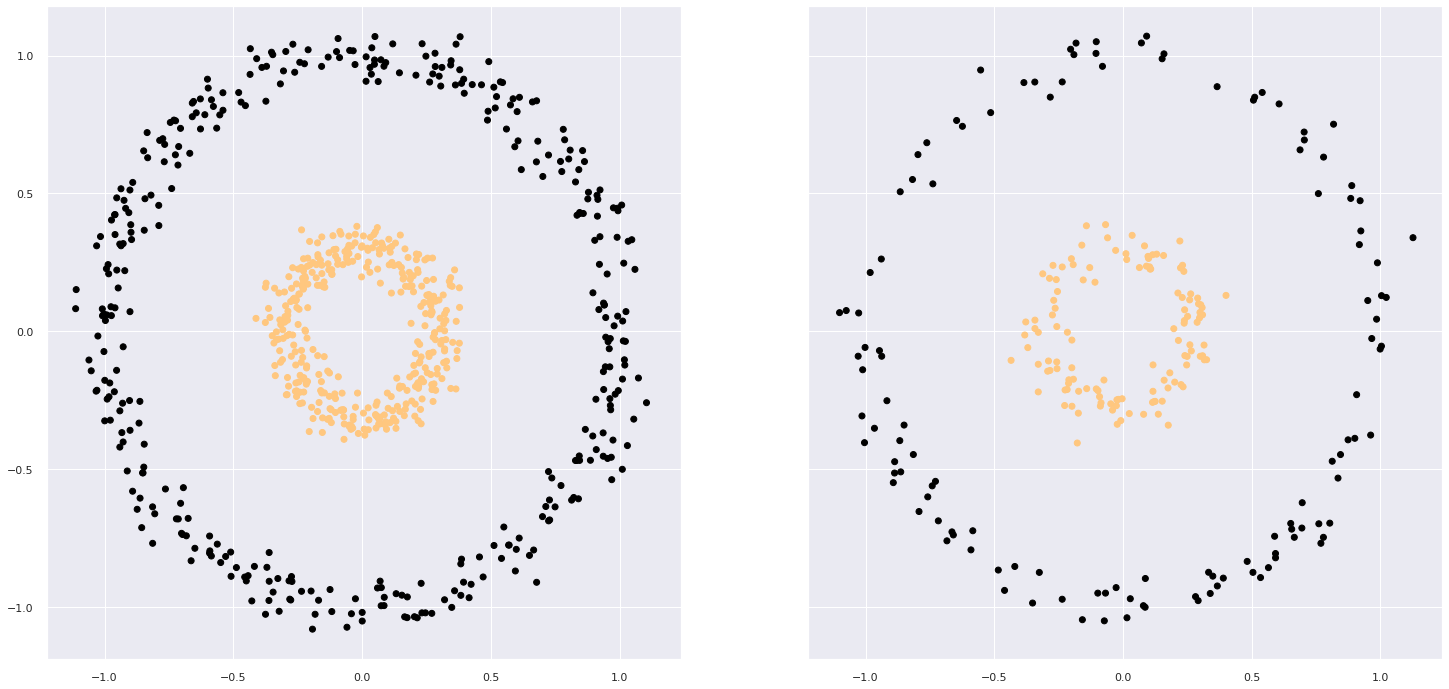

In [ ]:
_, (ax1, ax2)=plt.subplots(ncols=2, sharex=True, sharey=True)
ax1.scatter(x_train[:, 0], x_train[:, 1], c=y_train,cmap='copper');
ax2.scatter(x_test[:, 0], x_test[:, 1], c=y_test,cmap='copper');

In [ ]:
# embedding

# method definition
pca = dc.PCA(n_components=2)
kernel_pca=dc.KernelPCA(n_components=2, kernel='rbf', gamma=10, fit_inverse_transform=True, alpha=0.1)

# embedding application
x_test_pca=pca.fit(x_train).transform(x_test)
x_test_kpca=kernel_pca.fit(x_train).transform(x_test)

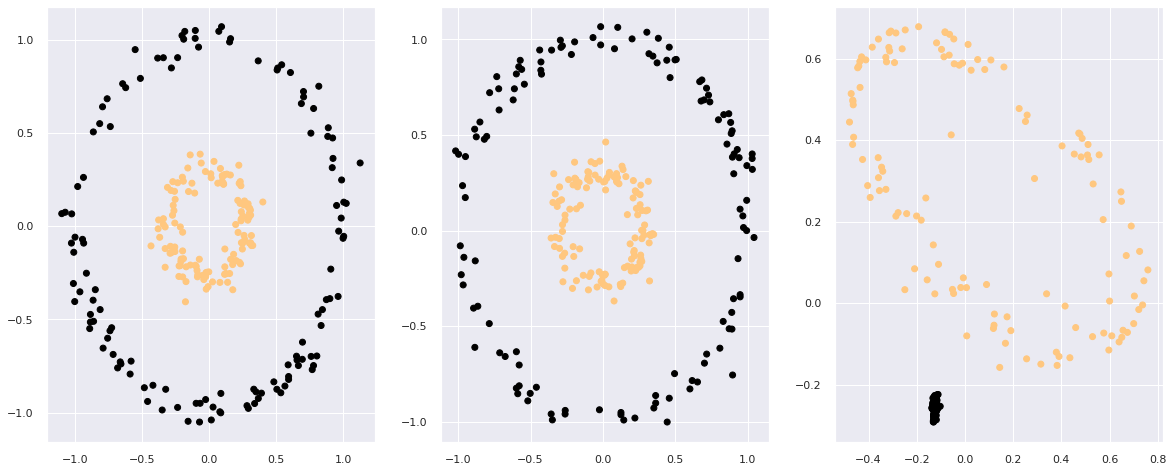

In [ ]:
_, (origin_data_ax, pca_proj_ax, kernel_pca_proj_ax)=plt.subplots( ncols=3, figsize=(20, 8))

origin_data_ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='copper');
pca_proj_ax.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test, cmap='copper');
kernel_pca_proj_ax.scatter(x_test_kpca[:, 0], x_test_kpca[:, 1], c=y_test, cmap='copper');

In [ ]:
# exp 2

In [ ]:
n_samples = 500
outliers_fractions = 0.05

n_features=2
n_clusters = 3

n_outliers= int(outliers_fractions * n_samples)
n_inliers= n_samples - n_outliers

blobs_params=dict(random_state=0, n_samples=n_inliers, n_features=n_features )
X,y=dt.make_blobs(centers=n_clusters, cluster_std=0.4, **blobs_params )

df=pd.DataFrame(X, columns=['x' + str(i) for i in list(range(1, n_features+1))])
df['class']=y

rng=np.random.RandomState(42)
df_noise=pd.DataFrame(rng.uniform(low=-6,
                      high=6,
                      size=(n_outliers, n_features)), columns=['x' + str(i) for i in list(range(1, n_features+1))])
df_noise['class']=-1

df_raw=pd.concat([df, df_noise], axis=0)
df_raw.head()

x1        x2  class
0 -1.831750  2.562770      2
1  0.969462  4.455448      0
2  1.252886  4.581687      0
3  0.593892  4.165395      0
4  1.185826  4.339156      0

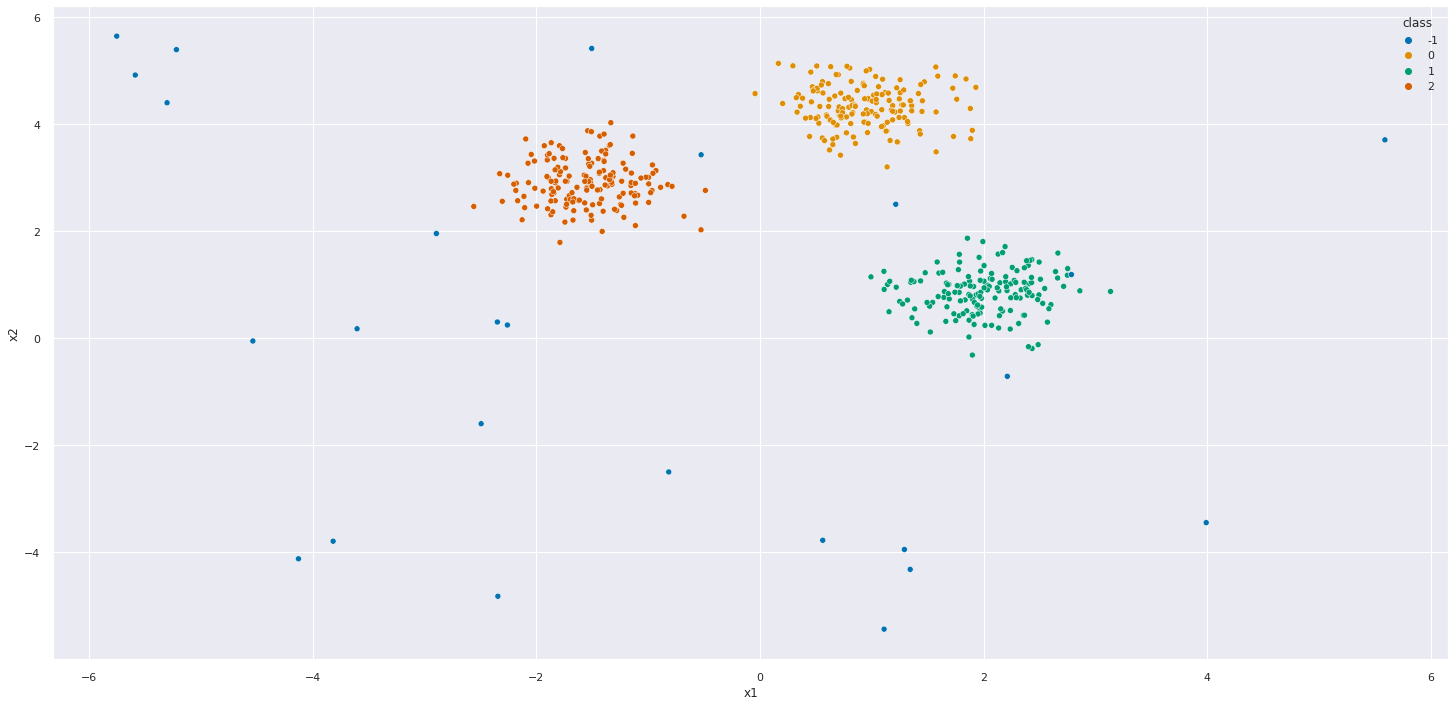

In [ ]:

sns.scatterplot(x=df_raw['x1'], y=df_raw['x2'], hue=df_raw['class'], palette='colorblind', data=df_raw );

In [ ]:
X=df_raw.drop('class', axis=1)
y=df_raw['class']
X.head()

x1        x2
0 -1.831750  2.562770
1  0.969462  4.455448
2  1.252886  4.581687
3  0.593892  4.165395
4  1.185826  4.339156

## embedding space

In [ ]:
# method definition
pca = dc.PCA(n_components=2)
# kernel_pca=dc.KernelPCA(n_components=2, kernel='rbf', gamma=10, fit_inverse_transform=True, alpha=0.1)
kernel_pca=dc.KernelPCA(n_components=2, kernel='rbf')
# kernel_pca=dc.KernelPCA(n_components=2, kernel='poly', degree=4)
# kernel_pca=dc.KernelPCA(n_components=2, kernel='sigmoid', degree=1)

# embedding application
x_pca=pca.fit_transform(X)
x_kpca=kernel_pca.fit_transform(X)

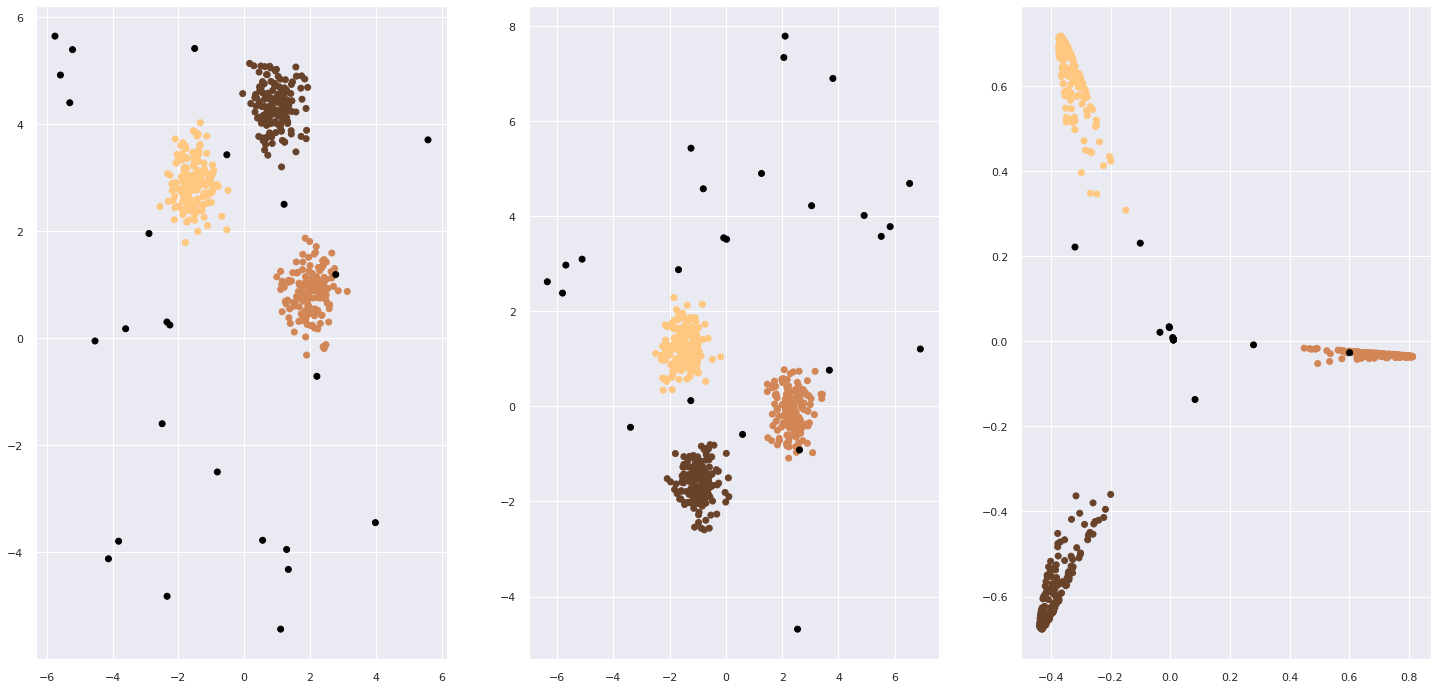

In [ ]:
_, (origin_data_ax, pca_proj_ax, kernel_pca_proj_ax)=plt.subplots( ncols=3)

origin_data_ax.scatter(X['x1'], X['x2'], c=y, cmap='copper');
pca_proj_ax.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='copper');
kernel_pca_proj_ax.scatter(x_kpca[:, 0], x_kpca[:, 1], c=y, cmap='copper');

# Fine tuning


In [ ]:
n_components=2
df_raw=pd.DataFrame(x_kpca, columns=['x' + str(i) for i in list(range(1, n_components+1))])
X=df_raw.copy()
X.shape

(500, 2)

In [ ]:
clusters = list(range(2, 9))
silhouette_list=[]
for k in clusters:
    # model definition and training
    kmeans_model=c.KMeans(n_clusters=k).fit(X)
    
    # predict
    labels=kmeans_model.predict(X)
    df_raw['labels']=labels

    # SS
    sil=m.silhouette_score(X, labels)
    silhouette_list.append(sil)

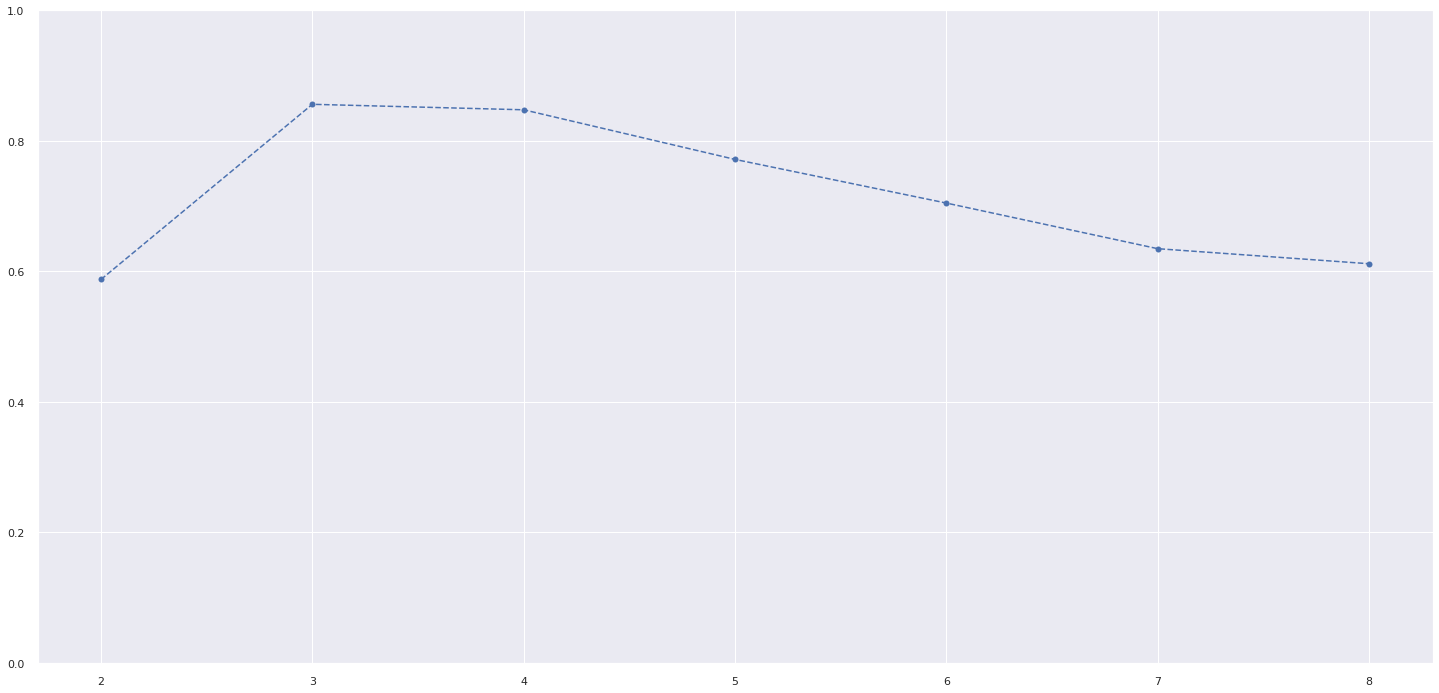

In [ ]:
plt.plot(clusters, silhouette_list, linestyle='--', marker='o', color='b');
plt.ylim([0, 1]);

In [ ]:
clusters = 3
silhouette_list=[]

# model definition and training
kmeans_model=c.KMeans(n_clusters=clusters).fit(X)

# predict
labels=kmeans_model.predict(X)
df_raw['labels']=labels

# SS
sil=m.silhouette_score(X, labels)
print(sil)

0.8561717158893628
